In [1]:
import importlib
import pandas as pd
import analysis_functions as af
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy import stats
import os
import pickle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter1d
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

Load & preprocess the data

In [3]:
# Load data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)
    data_ctl.pop(13) # no speed and lick in this animal's tst data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\behv data\v1tstdata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_tst = pickle.load(f)
    data_tst.pop(13) # no speed and lick data in this animal

# downsample all data from 1000fps to 10fps
for ani in data_ctl:
    data_ctl[ani]['grating_indices']['gr_1'] = np.array(data_ctl[ani]['grating_indices']['gr_1'])//100
    data_ctl[ani]['grating_indices']['gr_2'] = np.array(data_ctl[ani]['grating_indices']['gr_2'])//100
    data_ctl[ani]['trial_start_indices'] = np.array(data_ctl[ani]['trial_start_indices'])//100
    data_ctl[ani]['reward_indices'] = np.array(data_ctl[ani]['reward_indices'])//100
    num_groups = data_ctl[ani]['position'].shape[0] // 100
    data_ctl[ani]['position'] = np.array(data_ctl[ani]['position']).reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk
# downsample & process the speed data
    num_groups = data_ctl[ani]['speed'].shape[0] // 100
    data_ctl[ani]['speed'] = np.array(data_ctl[ani]['speed']).reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk
    data_ctl[ani]['speed'] = data_ctl[ani]['speed'] - np.percentile(data_ctl[ani]['speed'], 10)  # speed - percentile(speed)


# downsample all data from 1000fps to 10fps
for ani in data_tst:
    data_tst[ani]['grating_indices']['gr_1'] = np.array(data_tst[ani]['grating_indices']['gr_1'])//100
    data_tst[ani]['grating_indices']['gr_2'] = np.array(data_tst[ani]['grating_indices']['gr_2'])//100
    data_tst[ani]['trial_start_indices'] = np.array(data_tst[ani]['trial_start_indices'])//100
    data_tst[ani]['reward_indices'] = np.array(data_tst[ani]['reward_indices'])//100
    num_groups = data_tst[ani]['position'].shape[0] // 100
    data_tst[ani]['position'] = np.array(data_tst[ani]['position']).reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk
# downsample & process the speed data
    num_groups = data_tst[ani]['speed'].shape[0] // 100
    data_tst[ani]['speed'] = np.array(data_tst[ani]['speed']).reshape(num_groups, 100).mean(axis=1) # Reshape and compute the mean of every 100-frame chunk
    data_tst[ani]['speed'] = data_tst[ani]['speed'] - np.percentile(data_tst[ani]['speed'], 10)  # speed - percentile(speed)

In [7]:
600000*7.5/1000

4500.0

In [8]:
800000*7.5/1000

6000.0

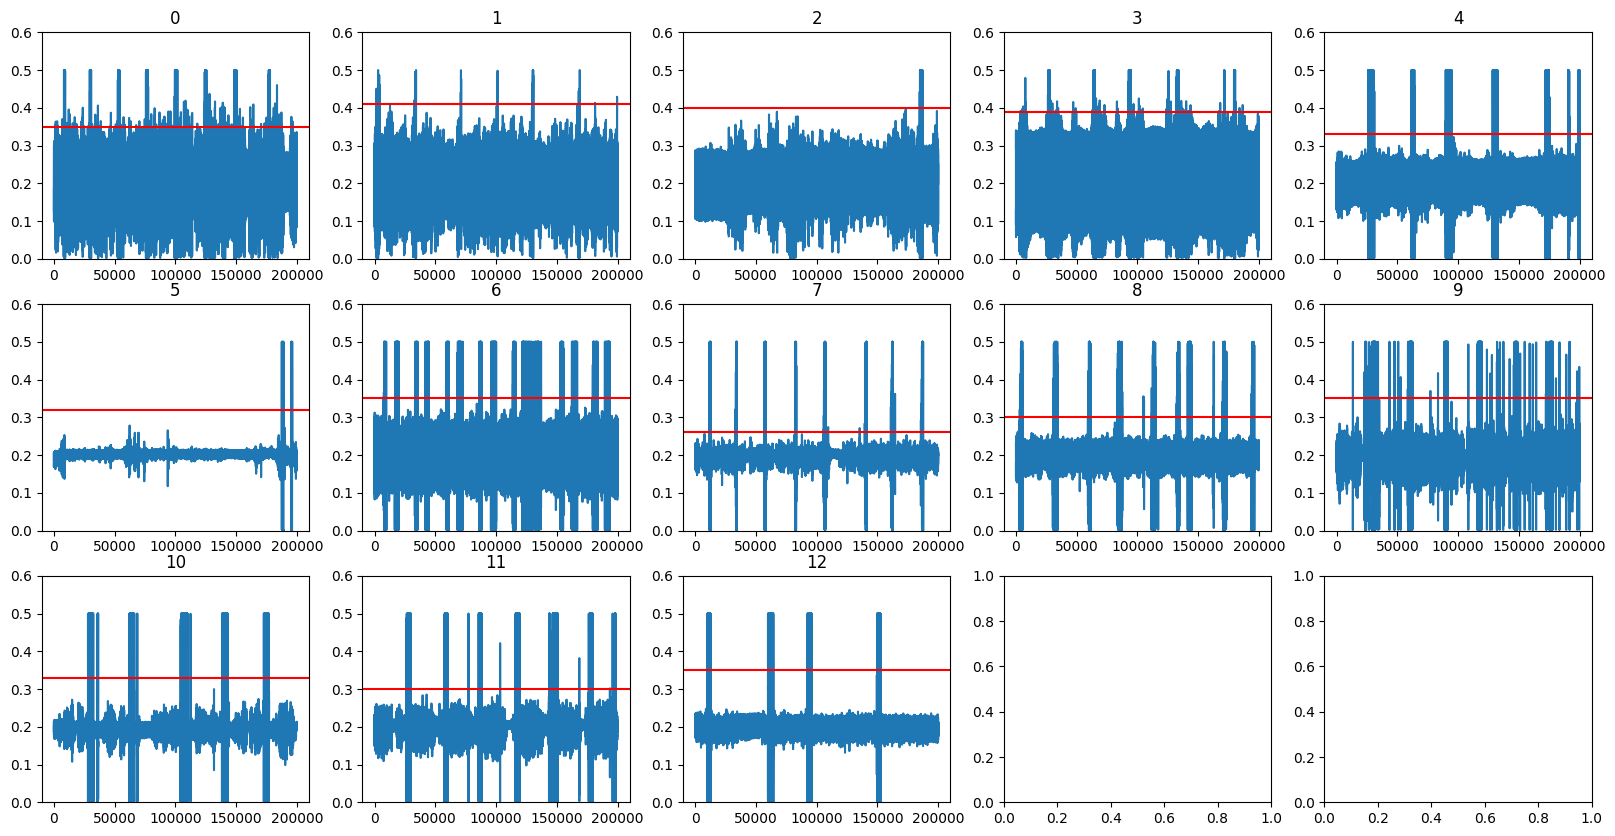

In [10]:
# Process&Visualise the lick data (ctl)

sample_rate = 1000
max_lick_rate = 10
lick_onsets_ctl = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 

threshold_list = [0.35, 0.41, 0.4, 0.39, 0.33, 0.32, 0.35, 0.26, 0.3, 0.35, 0.33, 0.3, 0.35, 0.35]


for ani in data_ctl:
    lick_onsets_ctl[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(data_ctl[ani]['lick'], a_min=None, a_max=max_valid)
    lick_signal = gaussian_filter1d(lick_signal, sigma= 1, axis=0)
    threshold = threshold_list[ani]
    # threshold = 0.32
    axes[ani].plot(lick_signal[600000:800000])
    # axes[ani].plot(lick_signal)
    axes[ani].axhline(threshold, color='red')
    axes[ani].set_ylim([0,0.6])
    axes[ani].set_title(f'{ani}')


#     above = lick_signal > threshold
#     min_interval = sample_rate/max_lick_rate #  refractory period
#     crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1  
#     if len(crossings) > 0:
#         lick_onsets_ctl[ani] = [crossings[0]]
#         for idx in crossings[1:]:
#             if idx - lick_onsets_ctl[ani][-1] >= min_interval:
#                 lick_onsets_ctl[ani].append(idx)
#         lick_onsets_ctl[ani] = np.array(lick_onsets_ctl[ani])
#     else:
#         lick_onsets_ctl[ani] = np.array([])

# print(lick_onsets_ctl[12])

# # calculate the lick_record and lick_rate
# lick_record_ctl = {}
# for ani in data_ctl:
#     lick_record_ctl[ani] = np.zeros(int(data_ctl[ani]['lick'].shape[0]//min_interval))
#     down_sampled_lick_onsets = lick_onsets_ctl[ani]//100
#     for num in down_sampled_lick_onsets:
#         lick_record_ctl[ani][num] = 1

# print(down_sampled_lick_onsets)

# lick_rate_ctl = {}
# frame_rate = 10 
# window_frames = frame_rate 
# for ani in data_ctl:
#     lick_series = pd.Series(lick_record_ctl[ani])
#     lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()  # Rolling sum over 1s window
#     lick_rate_ctl[ani] = np.array(lick_count)   # Convert to licks/sec (since window is 1 sec, no need to change)

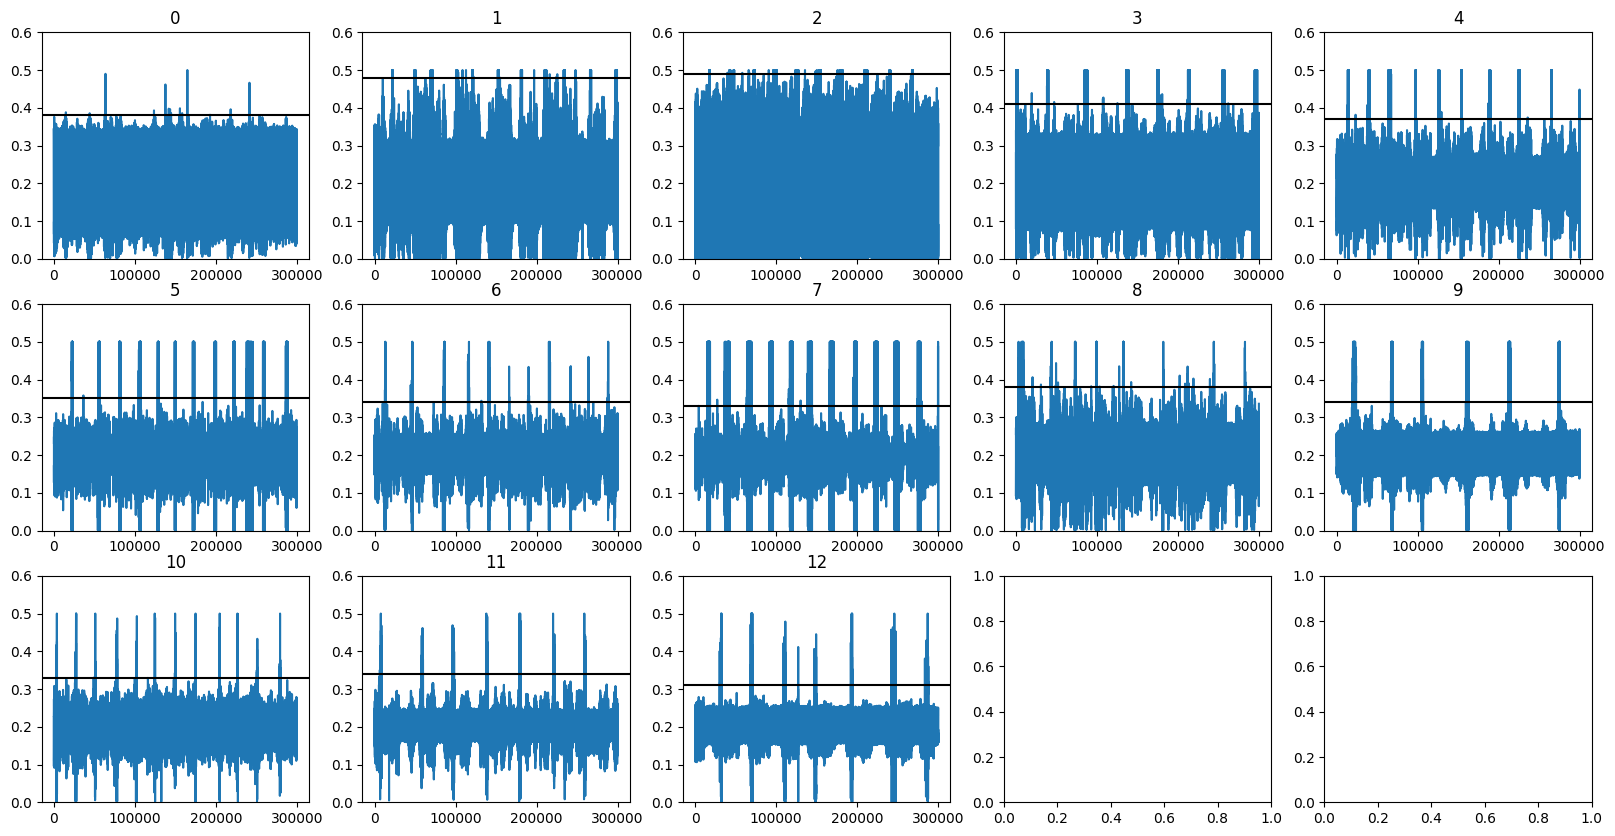

In [5]:
# process&visualise the lick data (tst)

sample_rate = 1000
max_lick_rate = 10
lick_onsets_tst = {}
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten() 

threshold_list = [0.38, 0.48, 0.49, 0.41, 0.37, 0.35, 0.34, 0.33, 0.38, 0.34, 0.33, 0.34, 0.31]


for ani in data_tst:
    lick_onsets_tst[ani] = []
    max_valid =  0.5  # upper bound for real licks vs animal pushing licktube
    lick_signal = np.clip(data_tst[ani]['lick'], a_min=None, a_max=max_valid)
    # lick_signal = gaussian_filter1d(lick_signal, sigma= 1, axis=0)
    # lick_signal = lick_signal - np.percentile(lick_signal, 50)
    # threshold = np.percentile(lick_signal,99,axis=0) 
    threshold = threshold_list[ani]   # fixed threshold looks better--- some animals has quite low piezo signal so 99% is not high enough for them but already too high for other animals 
    # threshold = 0.4
    axes[ani].plot(lick_signal[2500000:2800000])
    axes[ani].axhline(threshold, color='k')
    axes[ani].set_ylim([0,0.6])
    axes[ani].set_title(f'{ani}')
    above = lick_signal > threshold
    min_interval = sample_rate/max_lick_rate #  refractory period
    crossings = np.where((~above[:-1]) & (above[1:]))[0] + 1  
    if len(crossings) > 0:
        lick_onsets_tst[ani] = [crossings[0]]
        for idx in crossings[1:]:
            if idx - lick_onsets_tst[ani][-1] >= min_interval:
                lick_onsets_tst[ani].append(idx)
        lick_onsets_tst[ani] = np.array(lick_onsets_tst[ani])
    else:
        lick_onsets_tst[ani] = np.array([])


# calculate the lick_record and lick_rate
lick_record_tst = {}
for ani in data_tst:
    lick_record_tst[ani] = np.zeros(int(data_tst[ani]['lick'].shape[0]//min_interval))
    down_sampled_lick_onsets = lick_onsets_tst[ani]//100
    for num in down_sampled_lick_onsets:
        lick_record_tst[ani][num] = 1
lick_rate_tst = {}
frame_rate = 10 
window_frames = frame_rate 
for ani in data_tst:
    lick_series = pd.Series(lick_record_tst[ani])
    # Rolling sum over 1s window
    lick_count = lick_series.rolling(window=window_frames, min_periods=1).sum()
    # Convert to licks/sec (since window is 1 sec, no need to change)
    lick_rate_tst[ani] = np.array(lick_count)


Lick Near reward for each animal

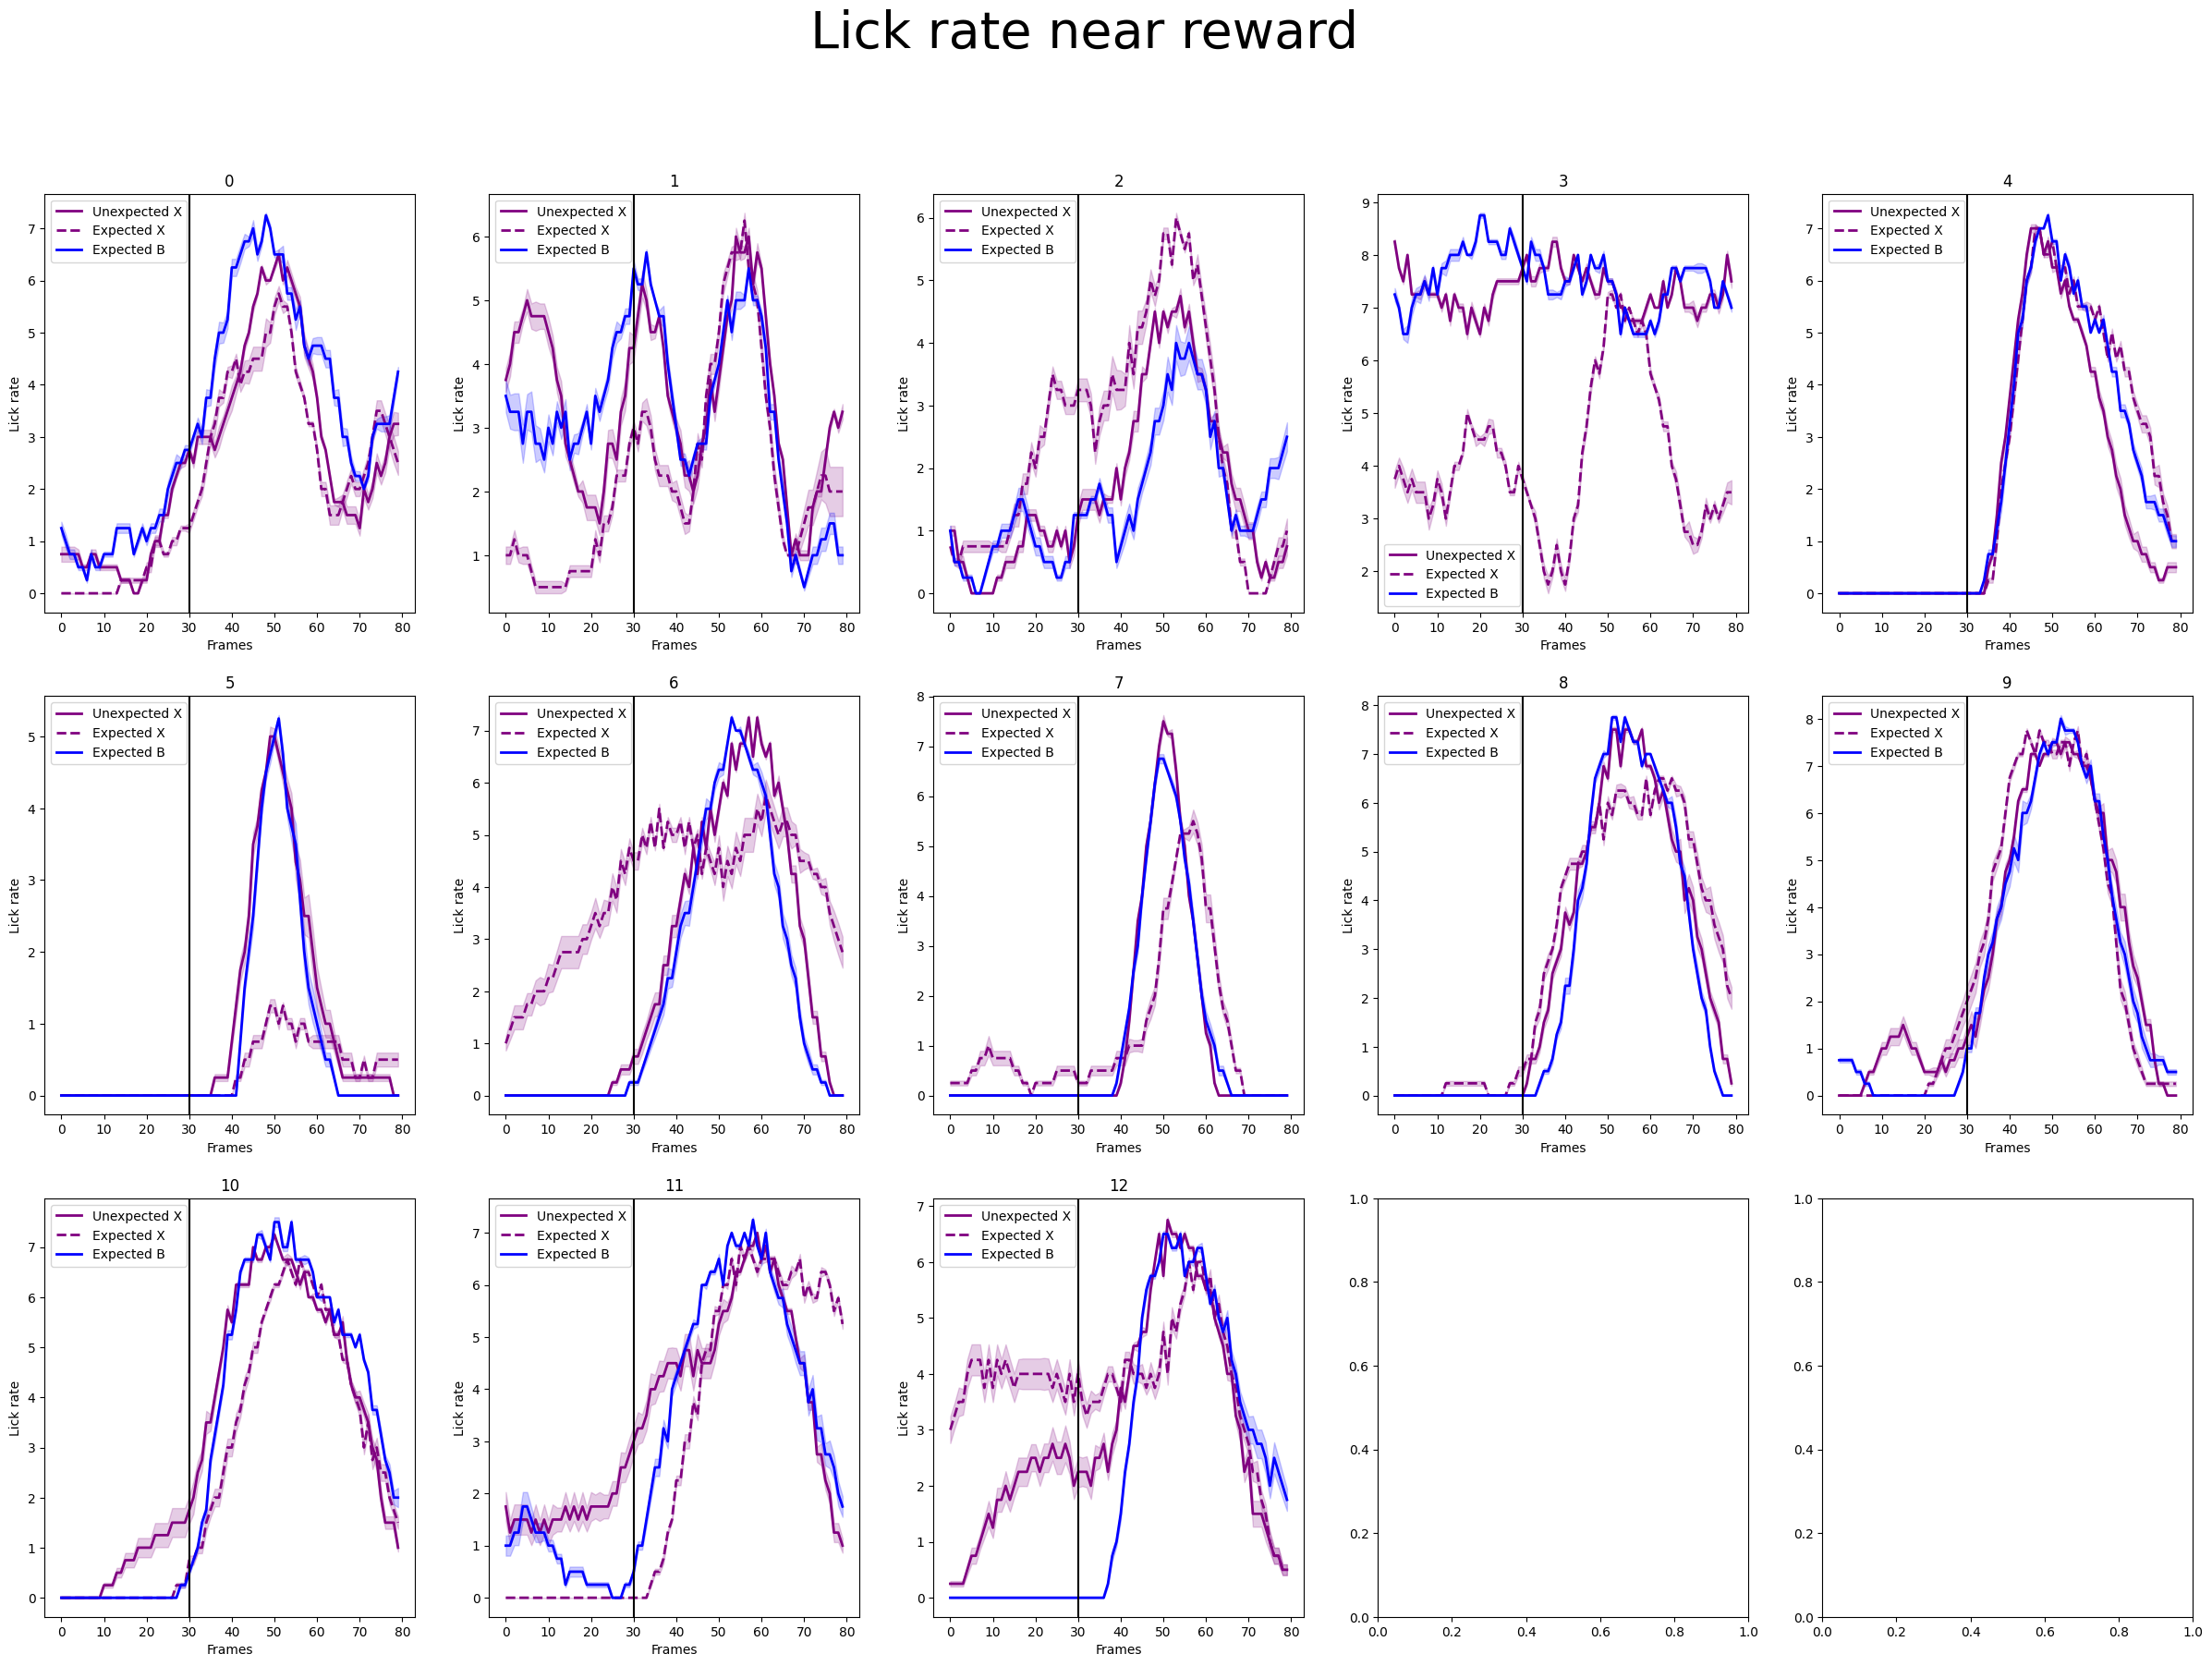

In [ ]:
# Lick Near Reward for each animal ctl
unexp_rw_ctl = {}
exp_rw_ctl = {}
for ani in data_ctl:
    unexp_rw_ctl[ani] = []
    exp_rw_ctl[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw_ctl[ani].append(range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+50)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:
            exp_rw_ctl[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+50))
fig, axes = plt.subplots(3, 5, figsize=(30, 20)) 
fig.suptitle("Lick rate near reward", fontsize=40)
t_frames = 80
for i, ani in enumerate(data_ctl):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][unexp_rw_ctl[ani][:4]], color='purple', alpha=0.2, label='Unexpected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][unexp_rw_ctl[ani][6:10]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_ctl[ani][exp_rw_ctl[ani][:4]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([30], color='black')
    ax.set_ylabel('Lick rate')
    ax.set_xlabel('Frames')
    ax.set_title(f'{ani}')
    ax.legend()

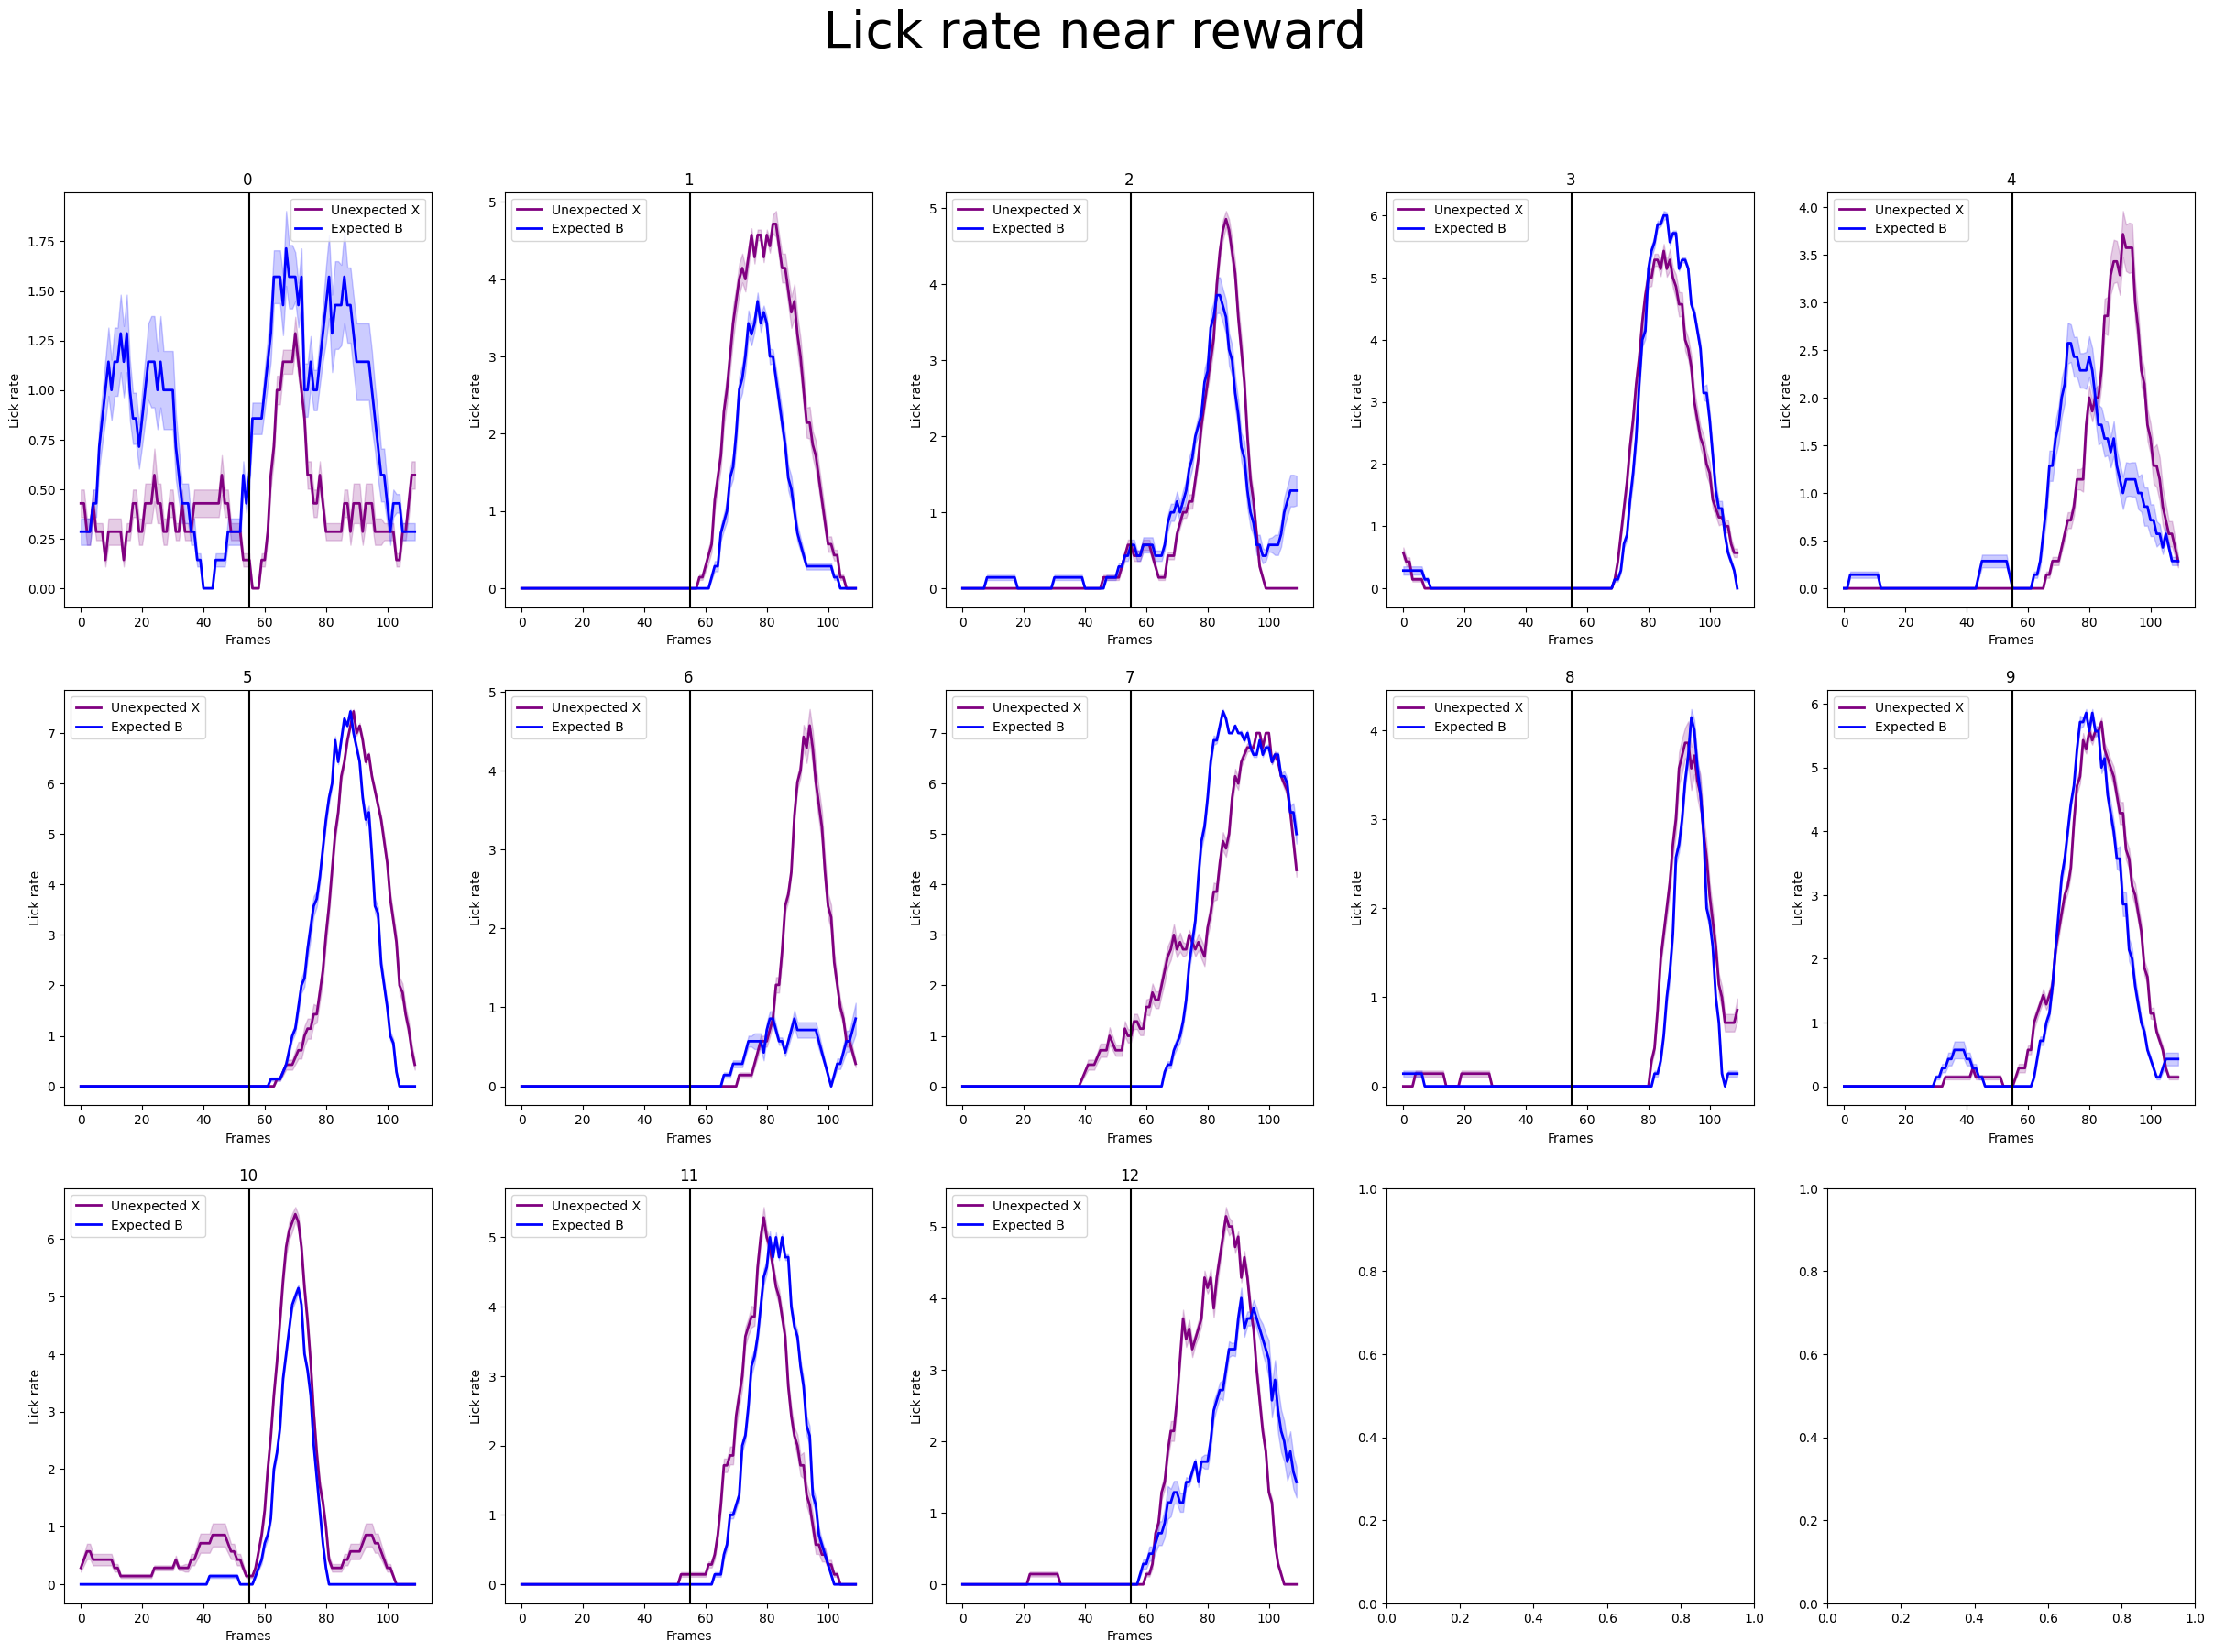

In [147]:
# Lick Near Reward for each animal tst

unexp_rw_tst = {}
exp_rw_tst = {}
for ani in data_tst:
    unexp_rw_tst[ani] = []
    exp_rw_tst[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw_tst[ani].append(range(data_tst[ani]['reward_indices'][trial]-55,data_tst[ani]['reward_indices'][trial]+55)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:
            exp_rw_tst[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-55,data_tst[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 5, figsize=(30, 20)) 
fig.suptitle("Lick rate near reward", fontsize=40)
t_frames = 110
for i, ani in enumerate(data_tst):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, range(t_frames), lick_rate_tst[ani][unexp_rw_tst[ani][:7]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), lick_rate_tst[ani][unexp_rw_tst[ani][20:27]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), lick_rate_tst[ani][exp_rw_tst[ani][7:14]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([55], color='black')
    ax.set_ylabel('Lick rate')
    ax.set_xlabel('Frames')
    ax.set_title(f'{ani}')
    ax.legend() 

Lick Raster Plots

In [6]:
def plot_lick_data(ani):
    ani_positions = data_ctl[ani]['position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_ctl[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_ctl[ani]['trial_start_indices']) - 1:   
            trial_end = data_ctl[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_ctl[ani]['position'])
        for num, lick in enumerate(lick_record_ctl[ani][trial_start:trial_end]):   # num is the index in [trial_start:trial_end]
            if lick == 1 and i in data_ctl[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_ctl[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[0].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[0].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
    axes[0].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Control')
    axes[0].set_xlabel('Position (cm)')
    axes[0].set_ylabel('Trial number')
    fig.suptitle('')

    ani_positions = data_tst[ani]['position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_tst[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_tst[ani]['trial_start_indices']) - 1:   
            trial_end = data_tst[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_tst[ani]['position'])
        for num, lick in enumerate(lick_record_tst[ani][trial_start:trial_end]):   # num is the index
            if lick == 1 and i in data_tst[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_tst[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    axes[1].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[1].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)    # 
    axes[1].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)     #
    axes[1].set_title('Test') 
    axes[1].set_xlabel('Position (cm)')
    plt.tight_layout()
    plt.show()


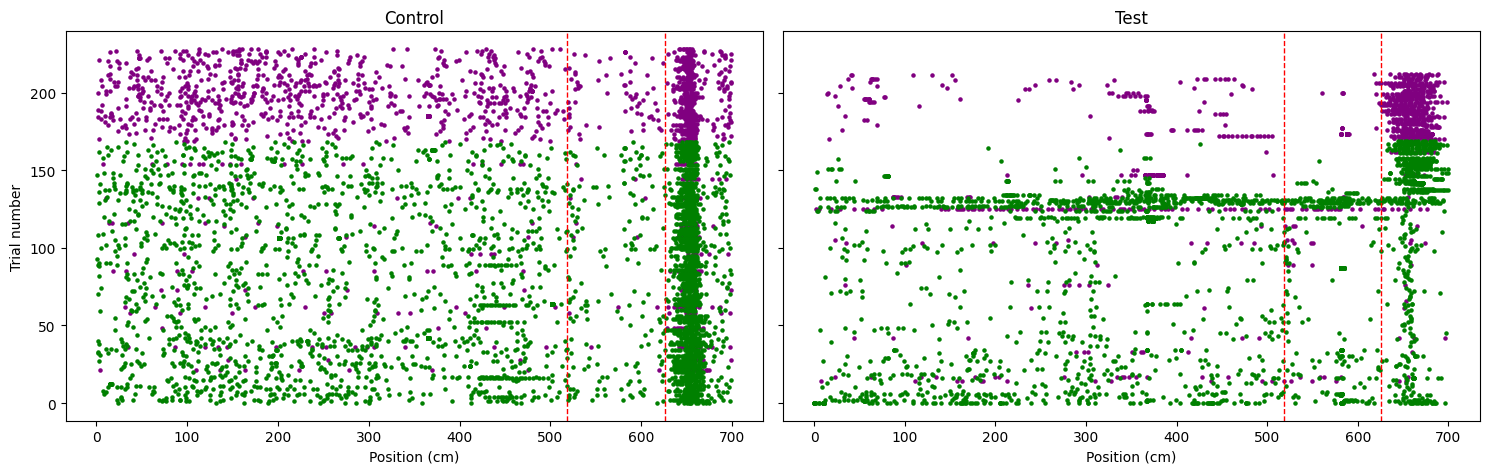

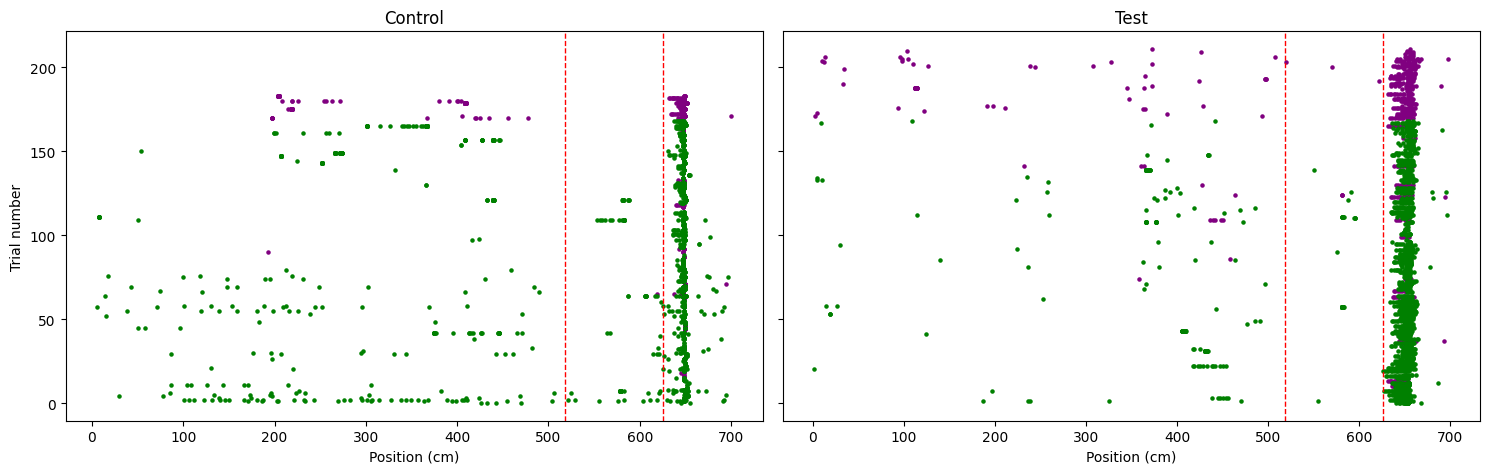

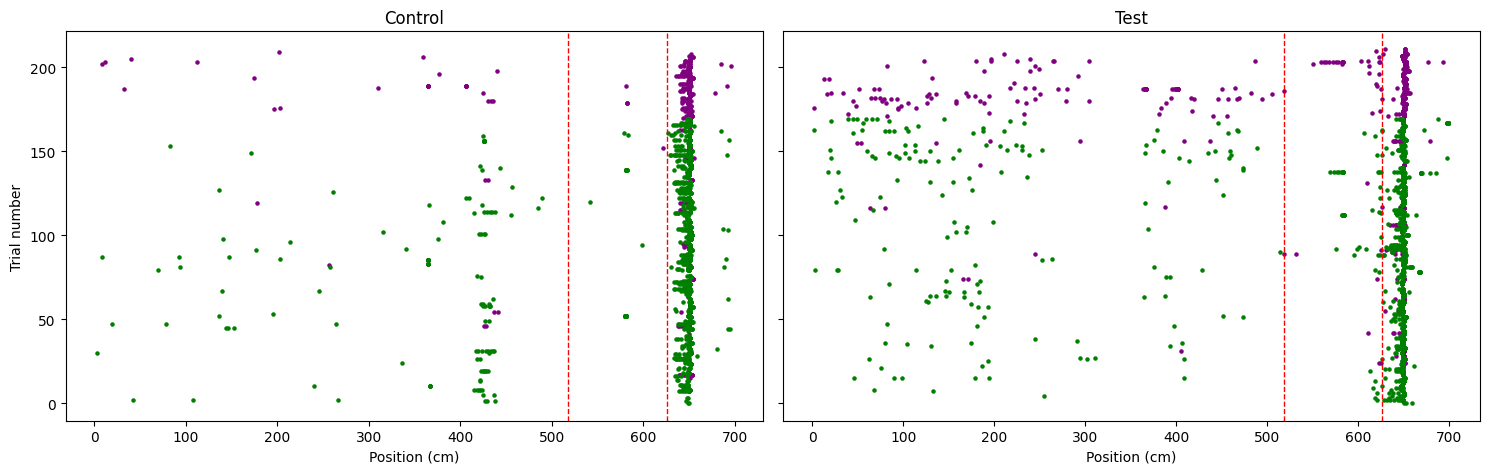

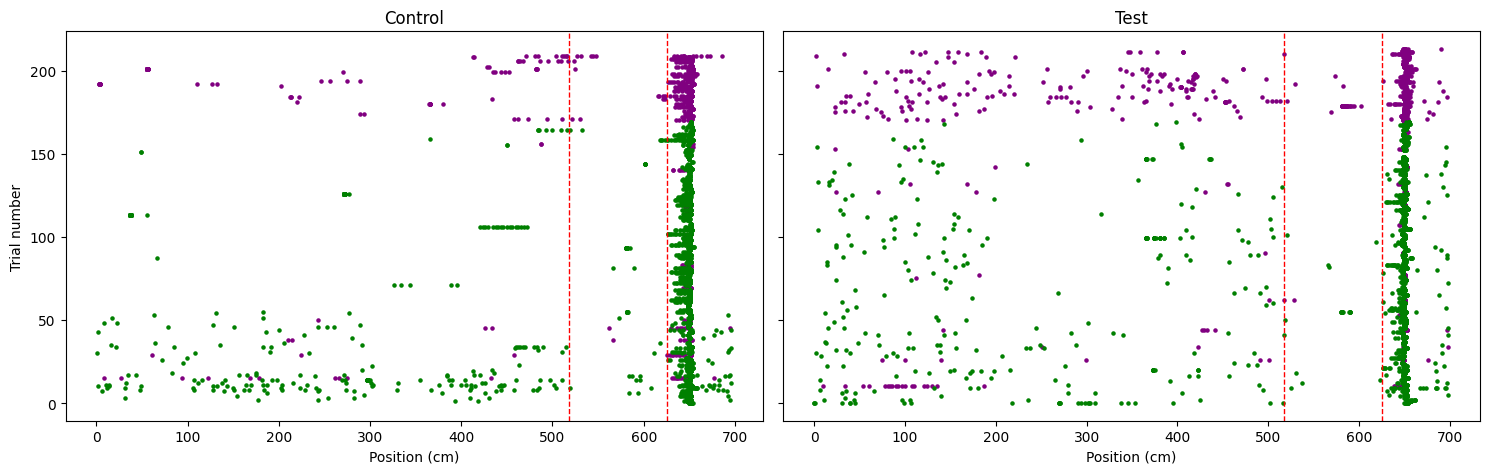

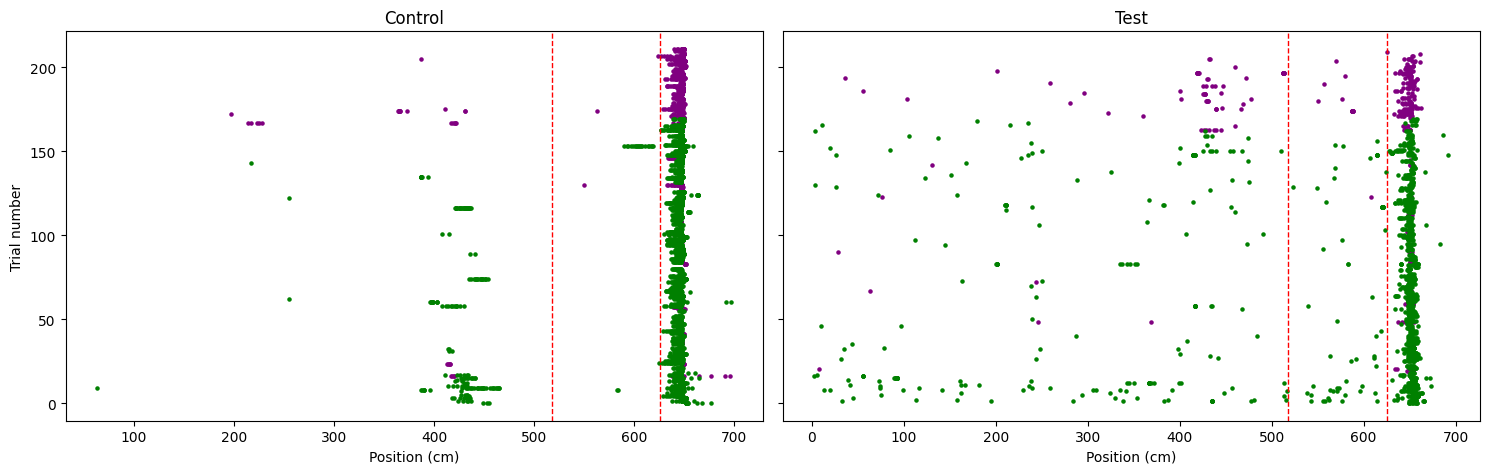

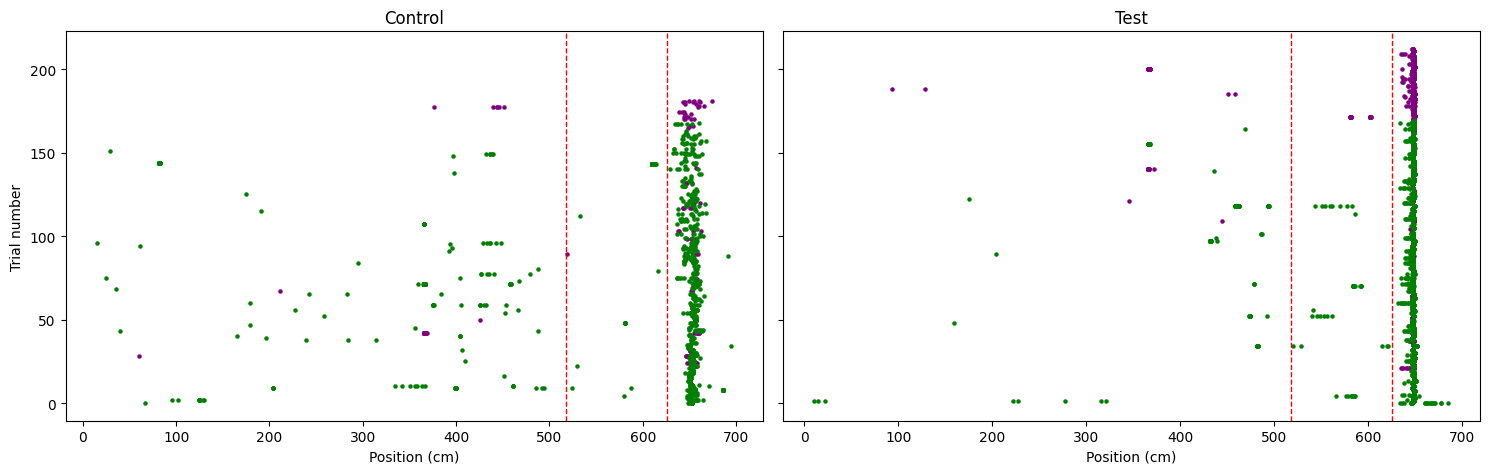

In [370]:
for ani in [0,1,2,3,4,5]:   # no anticipatory
    plot_lick_data(ani)

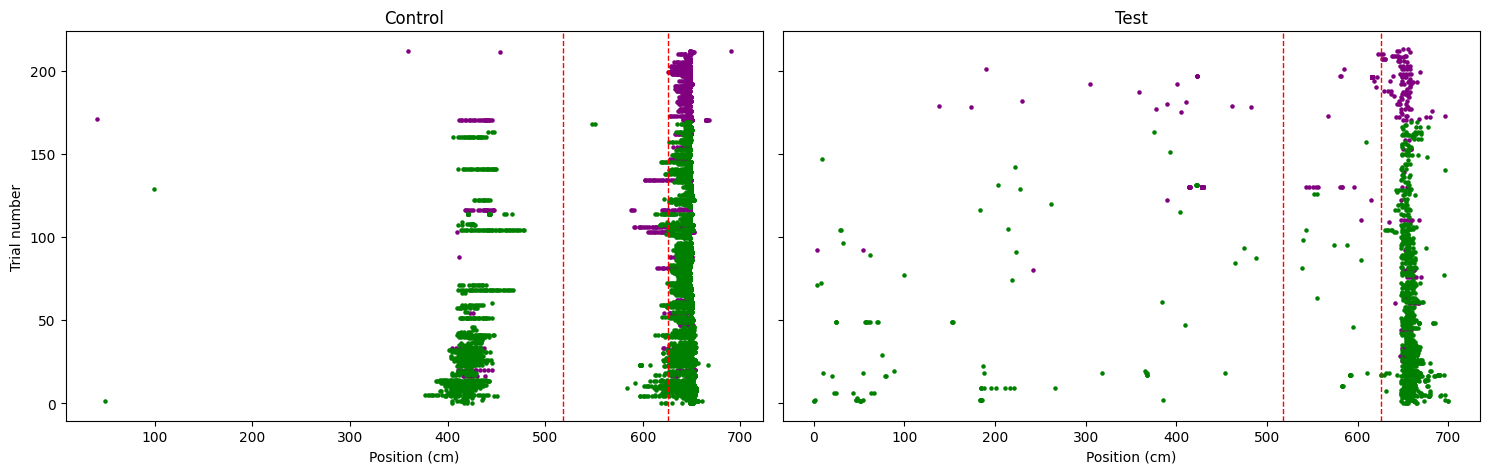

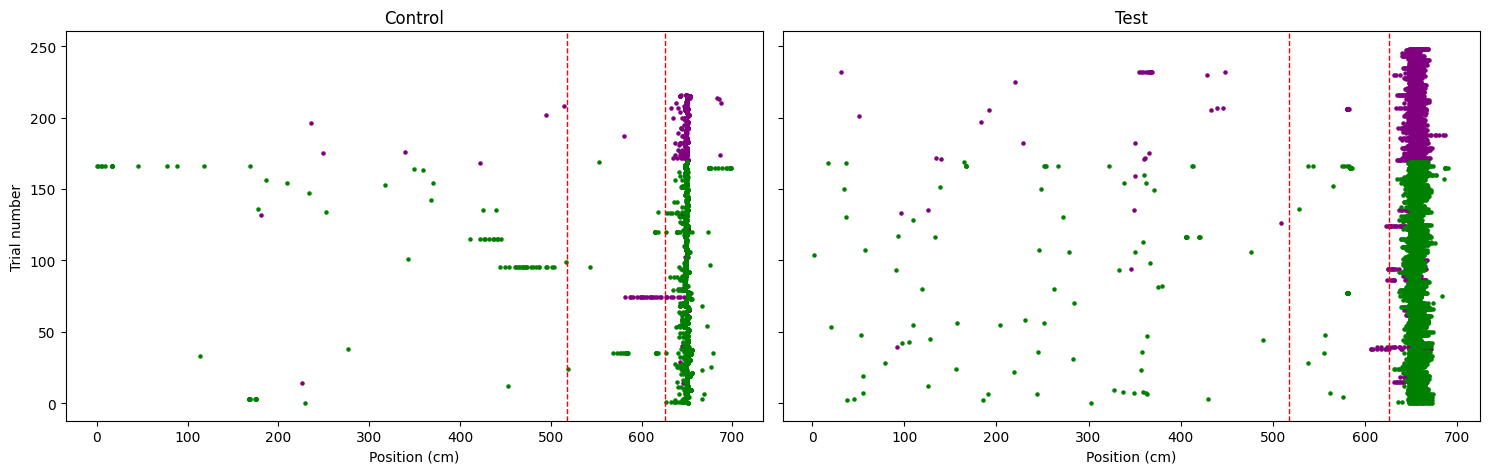

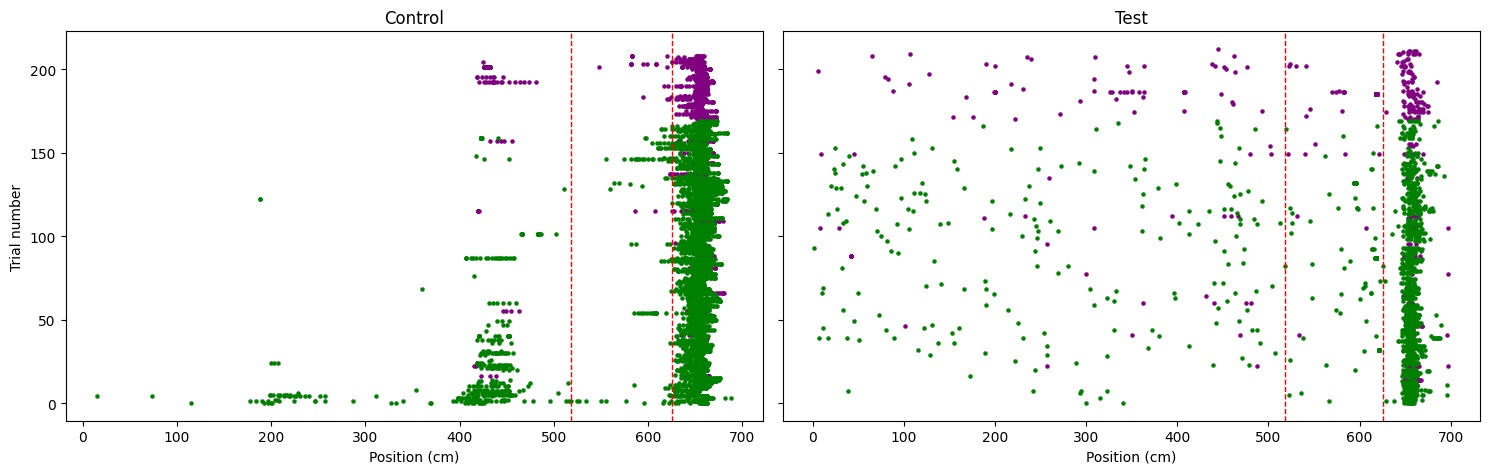

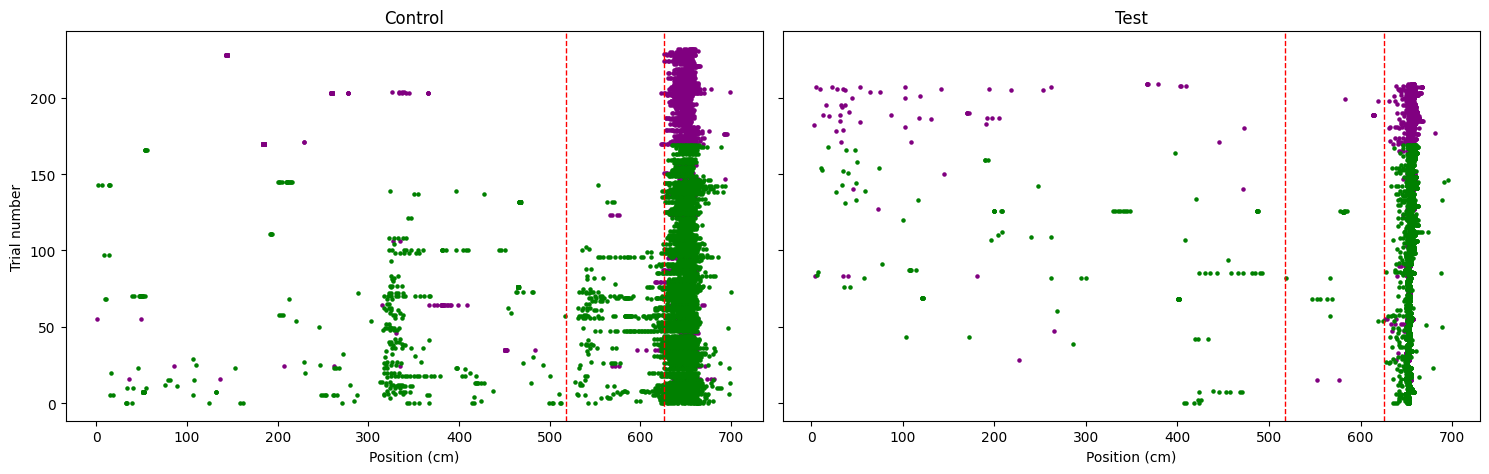

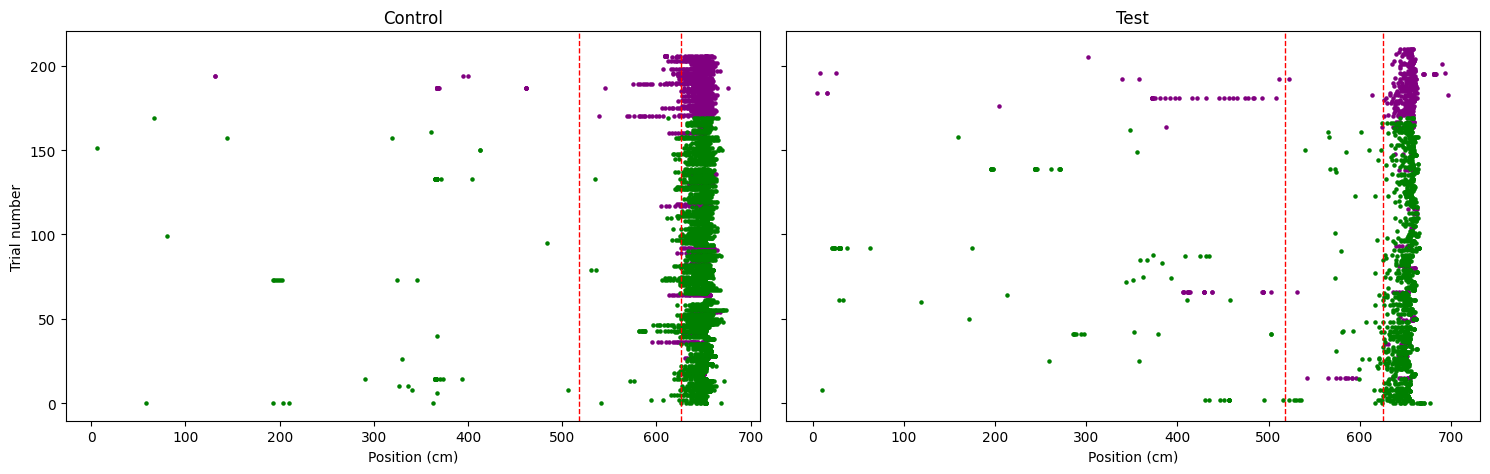

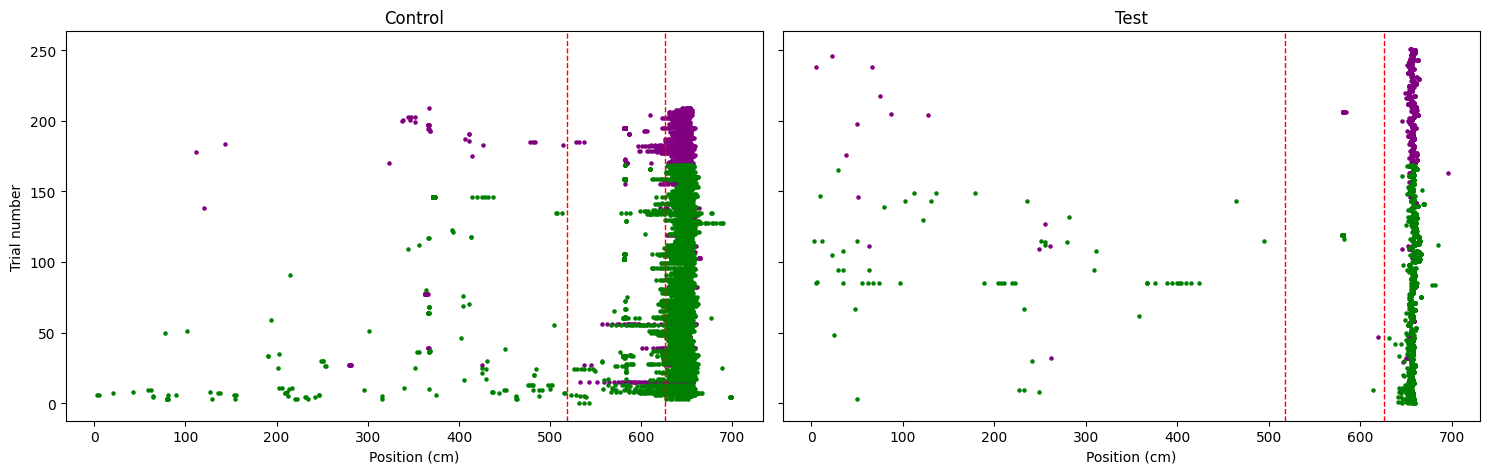

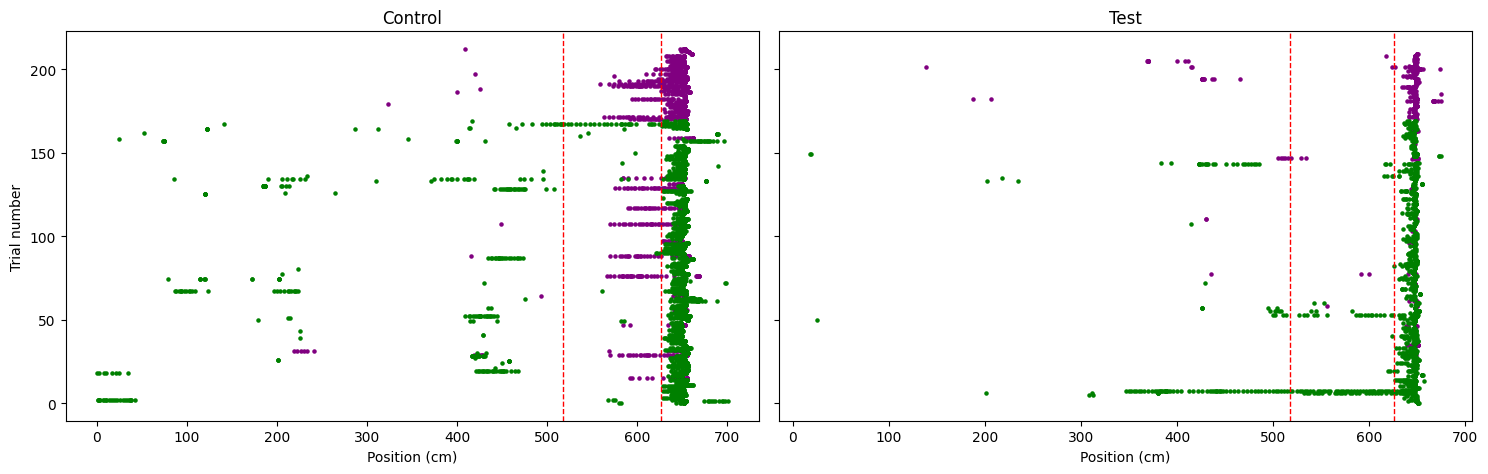

In [118]:
for ani in [6,7,8,9,10,11,12]:  # ancitipatory
    plot_lick_data(ani)

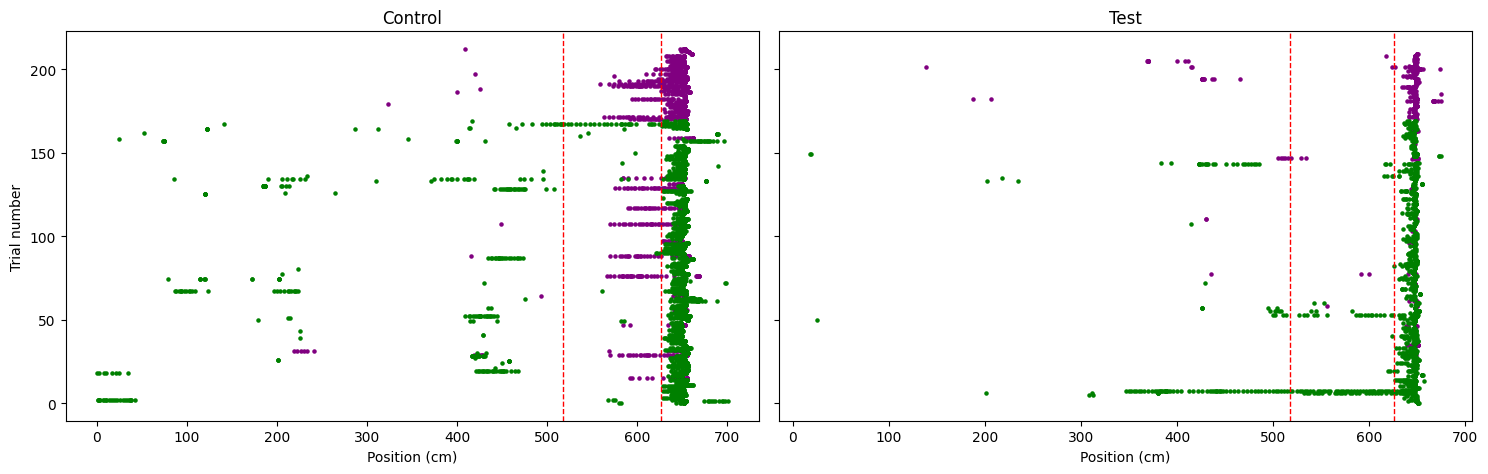

In [7]:
plot_lick_data(12)

In [ ]:
# 4 lick plots function

def plot_lick_data(ani):
    ani_positions = data_ctl[ani]['position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_ctl[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_ctl[ani]['trial_start_indices']) - 1:   
            trial_end = data_ctl[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_ctl[ani]['position'])
        for num, lick in enumerate(lick_record_ctl[ani][trial_start:trial_end]):   # num is the index
            if lick == 1 and i in data_ctl[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_ctl[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    axes = axes.flatten()
    # Unexpected trials
    axes[0].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[0].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)
    axes[0].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Unexpected Trials (ctl)')
    axes[0].set_xlabel('Position (cm)')
    axes[0].set_ylabel('Trial number')
    # Expected trials
    axes[1].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[1].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)
    axes[1].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
    axes[1].set_title('Expected Trials (ctl)')
    axes[1].set_xlabel('Position (cm)')

    ani_positions = data_tst[ani]['position'] * 700/5
    aligned_exp = []
    aligned_unexp = []
    for i, trial_start in enumerate(data_tst[ani]['trial_start_indices']):   # i is the trial number and trial_start is the index
        if i < len(data_tst[ani]['trial_start_indices']) - 1:   
            trial_end = data_tst[ani]['trial_start_indices'][i+1]   
        else:
            trial_end = len(data_tst[ani]['position'])
        for num, lick in enumerate(lick_record_tst[ani][trial_start:trial_end]):   # num is the index
            if lick == 1 and i in data_tst[ani]['unpred_trials']['gr_2']:
                aligned_unexp.append([i,ani_positions[trial_start:trial_end][num]])
            if lick == 1 and i in data_tst[ani]['pred_trials']:
                aligned_exp.append([i,ani_positions[trial_start:trial_end][num]])
    aligned_exp = np.array(aligned_exp)
    aligned_unexp = np.array(aligned_unexp)

    # Unexpected trials
    axes[2].scatter(aligned_unexp[:, 1], aligned_unexp[:, 0], s=5, c='purple')
    axes[2].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)
    axes[2].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
    axes[2].set_title('Unexpected Trials (tst)')
    axes[2].set_xlabel('Position (cm)')
    axes[2].set_ylabel('Trial number')
    # Expected trials
    axes[3].scatter(aligned_exp[:, 1], aligned_exp[:, 0], s=5, c='green')
    axes[3].axvline(x=3.7*700/5, color='red', linestyle='--', linewidth=1)
    axes[3].axvline(x=4.47*700/5, color='red', linestyle='--', linewidth=1)
    axes[3].set_title('Expected Trials (tst)')
    axes[3].set_xlabel('Position (cm)')
    plt.tight_layout()
    plt.show()




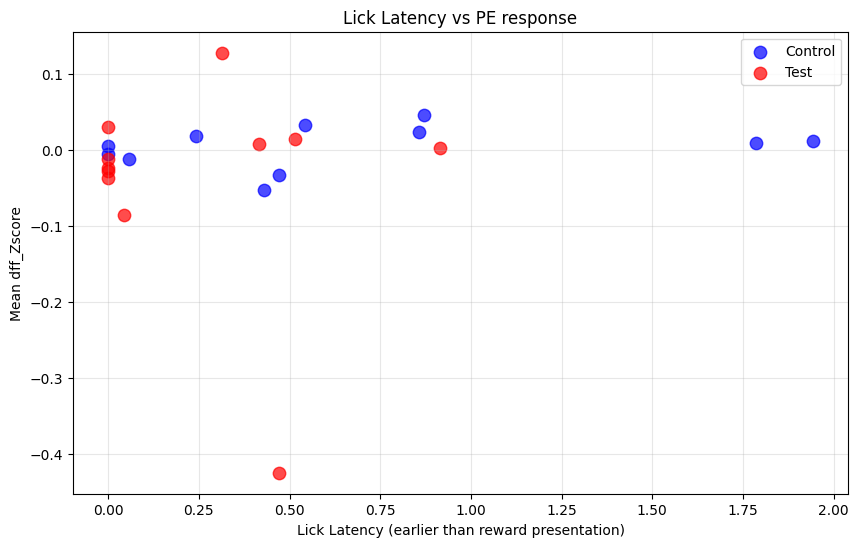

In [ ]:
# lick latency vs PE responses
results_ctl = []
results_tst = []
combined_results_ctl = []
combined_results_tst = []
all_animals = [1,3,4,5,6,7,8,9,10,11,12]

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_ctl[ani]['grating_indices']['gr_2'][trial]-30,data_ctl[ani]['grating_indices']['gr_2'][trial]+20))
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_ctl[ani]['grating_indices']['gr_2'][trial-1]-30,data_ctl[ani]['grating_indices']['gr_2'][trial-1]+20))
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-40,data_ctl[ani]['reward_indices'][trial]+40)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-40,data_ctl[ani]['reward_indices'][trial-1]+40))

for ani in all_animals:
    arr = lick_record_ctl[ani][exp_rw[ani][7:14]][:,0:40]
    first_lick_exp_B = []
    for row in arr:
        ones = np.where(row == 1)[0]   # np.where row == 1
        if len(ones) > 0:
            first_lick_exp_B.append(40 - ones[0]) 
        else:
            first_lick_exp_B.append(0)
    arr = lick_record_ctl[ani][unexp_rw[ani][0:7]][:,0:40]
    first_lick_unexp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(40 - ones[0]) 
        else:
            first_lick_unexp_X.append(0)
    if num == 0:
        arr = lick_record_ctl[ani][unexp_rw[ani][20:27]][:,0:40]  
    else:
        arr = lick_record_ctl[ani][unexp_rw[ani][7:14]][:,0:40]   # test data don't have unexp trial 20-27 so use 7-14
    first_lick_exp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(40 - ones[0]) 
        else:
            first_lick_exp_X.append(0)
    results_ctl.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results_ctl = np.array(results_ctl)/10
for i, ani in enumerate(all_animals):
    combined_results_ctl.append([results_ctl[i][1],np.mean(np.mean(np.mean(data_ctl[ani]['dff_Zscore'][:,unexp_grat[ani][:7]],axis=1),axis=1),axis=0)])


unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial]-25,data_tst[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial-1]-25,data_tst[ani]['grating_indices']['gr_2'][trial-1]+55))
unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-40,data_tst[ani]['reward_indices'][trial]+40)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-40,data_tst[ani]['reward_indices'][trial-1]+40))

for ani in all_animals:
    arr = lick_record_tst[ani][exp_rw[ani][7:14]][:,0:40]
    first_lick_exp_B = []
    for row in arr:
        ones = np.where(row == 1)[0]   # np.where row == 1
        if len(ones) > 0:
            first_lick_exp_B.append(40 - ones[0]) 
        else:
            first_lick_exp_B.append(0)
    arr = lick_record_tst[ani][unexp_rw[ani][0:7]][:,0:40]
    first_lick_unexp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]  
        if len(ones) > 0:
            first_lick_unexp_X.append(40 - ones[0]) 
        else:
            first_lick_unexp_X.append(0)
    if num == 0:
        arr = lick_record_tst[ani][unexp_rw[ani][20:27]][:,0:40]  
    else:
        arr = lick_record_tst[ani][unexp_rw[ani][7:14]][:,0:40]   # test data don't have unexp trial 20-27 so use 7-14
    first_lick_exp_X = []
    for row in arr:
        ones = np.where(row == 1)[0]
        if len(ones) > 0:
            first_lick_exp_X.append(40 - ones[0]) 
        else:
            first_lick_exp_X.append(0)
    results_tst.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
results_tst = np.array(results_tst)/10
for i, ani in enumerate(all_animals):
    combined_results_tst.append([results_tst[i][1],np.mean(np.mean(np.mean(data_tst[ani]['dff_Zscore'][:,unexp_grat[ani][:7]],axis=1),axis=1),axis=0)])


x_ctl = [result[0] for result in combined_results_ctl]  # first_lick_unexp_X
y_ctl = [result[1] for result in combined_results_ctl]  # average dff_Zscore
x_tst = [result[0] for result in combined_results_tst]  # first_lick_unexp_X
y_tst = [result[1] for result in combined_results_tst]  # average dff_Zscore

plt.figure(figsize=(10, 6))
plt.scatter(x_ctl, y_ctl, color='blue', label='Control', alpha=0.7, s=80)
plt.scatter(x_tst, y_tst, color='red', label='Test', alpha=0.7, s=80)
plt.xlabel('Lick Latency (earlier than reward presentation)')
plt.ylabel('Mean dff_Zscore')
plt.title('Lick Latency vs PE response')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

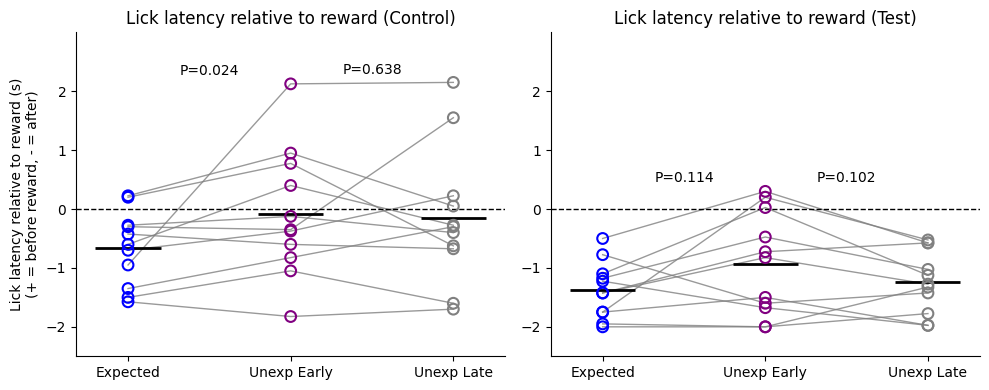

In [54]:
# Lick latency three points plot

fig, ax = plt.subplots(1,2, figsize=(10,4))

for num,lick_record in enumerate([lick_record_ctl,lick_record_tst]):
    results = []
    # all_animals = [1,2,3,4,5,6,7,8,9,10,11,12]
    all_animals = [1,3,4,5,6,7,8,9,10,11,12]
    
    if num == 0:
        unexp_rw = {}
        exp_rw = {}
        for ani in data_ctl:
            unexp_rw[ani] = []
            exp_rw[ani] = []
            for trial in data_ctl[ani]['unpred_trials']['gr_2']:
                if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
                    unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-30,data_ctl[ani]['reward_indices'][trial]+20)) 
            for trial in data_ctl[ani]['unpred_trials']['gr_2']:
                if trial < data_ctl[ani]['reward_indices'].shape[0]:
                    exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-30,data_ctl[ani]['reward_indices'][trial-1]+20))
    else:
        unexp_rw = {}
        exp_rw = {}
        for ani in data_tst:
            unexp_rw[ani] = []
            exp_rw[ani] = []
            for trial in data_tst[ani]['unpred_trials']['gr_2']:
                if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
                    unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-30,data_tst[ani]['reward_indices'][trial]+20)) 
            for trial in data_tst[ani]['unpred_trials']['gr_2']:
                if trial < data_tst[ani]['reward_indices'].shape[0]:
                    exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-30,data_tst[ani]['reward_indices'][trial-1]+20))        
    
    for ani in all_animals:
        arr = []
        arr = lick_record[ani][exp_rw[ani][6:10]][:,0:50]
        first_lick_exp_B = []
        for row in arr:
            ones = np.where(row == 1)[0]   # np.where row == 1
            if len(ones) > 0:
                first_lick_exp_B.append(30 - ones[0]) 
            else:
                first_lick_exp_B.append(-20)
        arr = []
        arr = lick_record[ani][unexp_rw[ani][0:4]][:,0:50]
        first_lick_unexp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]  
            if len(ones) > 0:
                first_lick_unexp_X.append(30 - ones[0]) 
            else:
                first_lick_unexp_X.append(-20)
        arr = []
        if num == 0:
            arr = lick_record[ani][unexp_rw[ani][6:10]][:,0:50]  
        else:
            arr = lick_record[ani][unexp_rw[ani][6:10]][:,0:50]   # test data don't have unexp trial 20-27 so use 7-14

        first_lick_exp_X = []
        for row in arr:
            ones = np.where(row == 1)[0]
            if len(ones) > 0:
                first_lick_exp_X.append(30 - ones[0]) 
            else:
                first_lick_exp_X.append(-20)
        results.append([np.mean(first_lick_exp_B), np.mean(first_lick_unexp_X), np.mean(first_lick_exp_X)])
    results = np.array(results)/10  # convert frames to seconds

    colors = ['blue', 'purple', 'gray']
    x_positions = [1,2,3]
    for i, xpos in enumerate(x_positions):
        ax[num].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
    for animal in results:
        ax[num].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
    for i in range(results.shape[1]):
        mean_val = np.mean(results[:, i])
        ax[num].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
    # pairwise test
    pairs = [(0,1), (0,2), (1,2)]
    labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
    pvals = []
    for (i,j), label in zip(pairs, labels):
        stat, p = wilcoxon(results[:,i], results[:,j])
        pvals.append(p)
        # print(label, "Wilcoxon p =", p)
    ax[num].set_xticks([1, 2, 3])
    ax[num].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[num].spines['top'].set_visible(False)
    ax[num].spines['right'].set_visible(False)
    i, j = 0, 1 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
    i, j = 1, 2 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1  
    ax[num].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
    ax[num].axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax[num].set_ylim([-2.5, 3])
    ax[num].set_yticks(range(-2, 3, 1))

ax[0].set_ylabel('Lick latency relative to reward (s)\n(+ = before reward, - = after)')
ax[0].set_title('Lick latency relative to reward (Control)')
ax[1].set_title('Lick latency relative to reward (Test)')
plt.tight_layout()
plt.show()

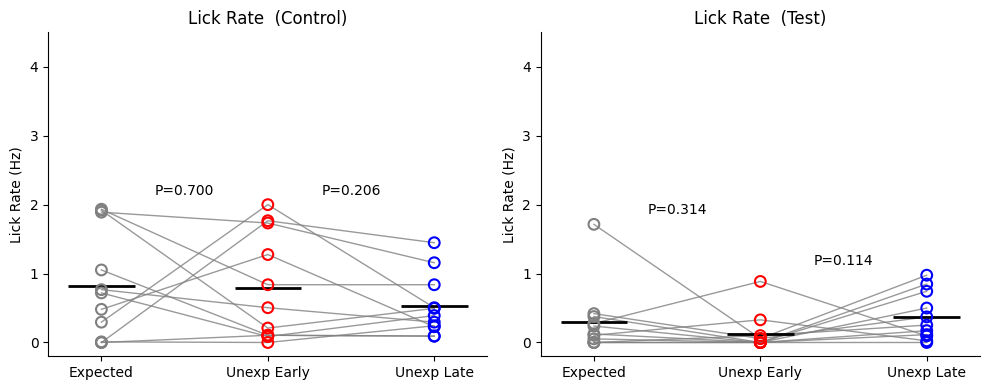

In [367]:
# Lick Rate  --- 3 seconds prior to reward

fig, ax = plt.subplots(1,2, figsize=(10,4))

for num, lick_rate in enumerate([lick_rate_ctl,lick_rate_tst]):
    results = []
    # all_animals = [1,2,3,4,5,6,7,8,9,10,11,12]
    all_animals = [1,3,4,5,6,7,8,9,10,11,12]
    for ani in all_animals:
        if num == 0:   
            results.append([np.mean(np.mean(lick_rate[ani][exp_rw[ani][7:14]][:,5:35], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][:7]][:,5:35], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][20:27]][:,5:35], axis = 0),axis = 0)])
        if num == 1:
            results.append([np.mean(np.mean(lick_rate[ani][exp_rw[ani][7:14]][:,5:35], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][:7]][:,5:35], axis = 0),axis = 0), np.mean(np.mean(lick_rate[ani][unexp_rw[ani][7:14]][:,5:35], axis = 0),axis = 0)])
    results = np.array(results)   # shape = (n_animals, 3)

    colors = ['gray', 'red', 'blue']
    x_positions = [1,2,3]
    for i, xpos in enumerate(x_positions):
        ax[num].scatter(np.full(results.shape[0], xpos), results[:, i], facecolors='none', edgecolors=colors[i], s=60, linewidth=1.5, zorder=3) # Plot scatter points for each animal
    for animal in results:
        ax[num].plot(x_positions, animal, color='gray', linewidth=1, alpha=0.8, zorder=2) # Connect each animal's points with a line
    for i in range(results.shape[1]):
        mean_val = np.mean(results[:, i])
        ax[num].hlines(mean_val, i+0.8, i+1.2, colors=colors[i], linewidth=2, color = 'black') # Plot mean horizontal lines
    # pairwise test
    pairs = [(0,1), (0,2), (1,2)]
    labels = ["Expected vs Unexp Early", "Expected vs Unexp Late", "Unexp Early vs Unexp Late"]
    pvals = []
    for (i,j), label in zip(pairs, labels):
        stat, p = wilcoxon(results[:,i], results[:,j])
        pvals.append(p)
        # print(label, "Wilcoxon p =", p)
    ax[num].set_ylim([-0.2,4.5])
    ax[num].set_xticks([1, 2, 3])
    ax[num].set_xticklabels(['Expected', 'Unexp Early', 'Unexp Late'])
    ax[num].spines['top'].set_visible(False)
    ax[num].spines['right'].set_visible(False)
    i, j = 0, 1 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1
    ax[num].text(x, y, f"P={pvals[0]:.3f}", ha='center', va='bottom')
    i, j = 1, 2 
    x = (i+1 + j+1) / 2 
    y = max(results[:,i].max(), results[:,j].max()) + 0.1  
    ax[num].text(x, y, f"P={pvals[2]:.3f}", ha='center', va='bottom')
    ax[num].set_ylabel('Lick Rate (Hz)')
ax[0].set_title(f'Lick Rate  (Control)')
ax[1].set_title(f'Lick Rate  (Test)')
plt.tight_layout()
plt.show()

Pupil Data

In [130]:
for ani in [0,4,5,7,8]:
    print(data_ctl[ani]['pupil'].shape)

(67700,)
(52599,)
(43518,)
(41931,)
(59823,)


In [131]:
for ani in [1,2,3,4,5,6,7,8,9,10,11,12]:
    print(data_tst[ani]['pupil'].shape)

(48066,)
(43020,)
(69714,)
(51315,)
(42514,)
(50841,)
(47662,)
(51026,)
(76634,)
(38371,)
(79289,)
(73834,)


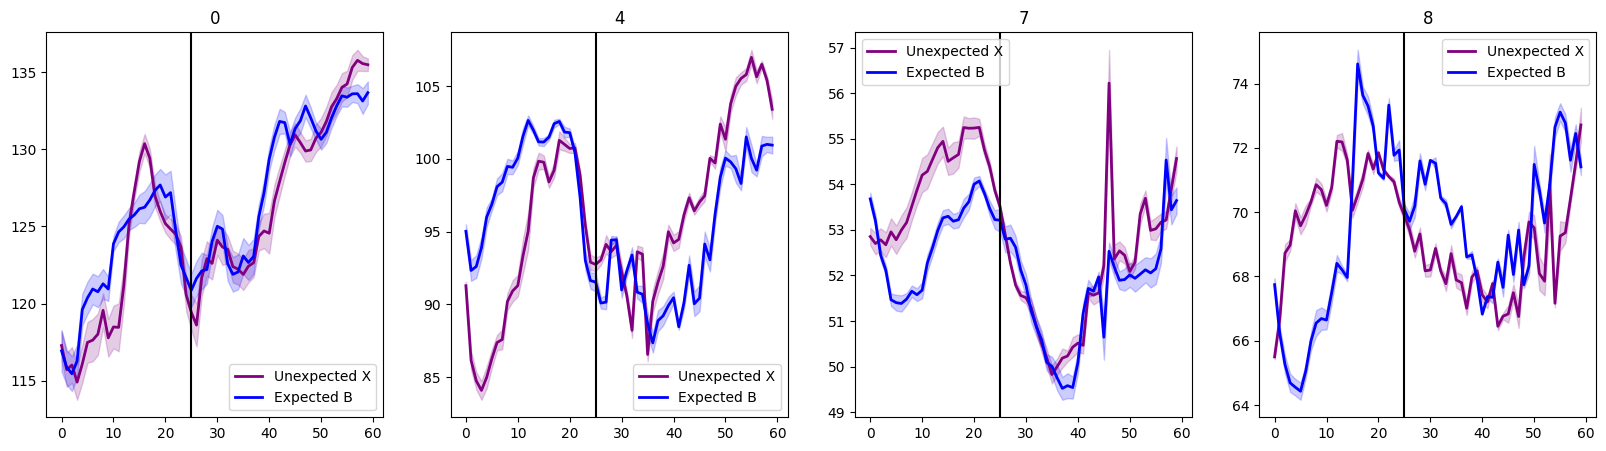

In [270]:
# Pupil Size near reward (Control)

unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(data_ctl[ani]['reward_indices'][trial]) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(data_ctl[ani]['reward_indices'][trial-1])

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
axes = axes.flatten()
t_frames = 60
for i, ani in enumerate([0,4,7,8]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][:4]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][7:14]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][exp_rw[ani][:4]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_title(f'{ani}')
    ax.legend()



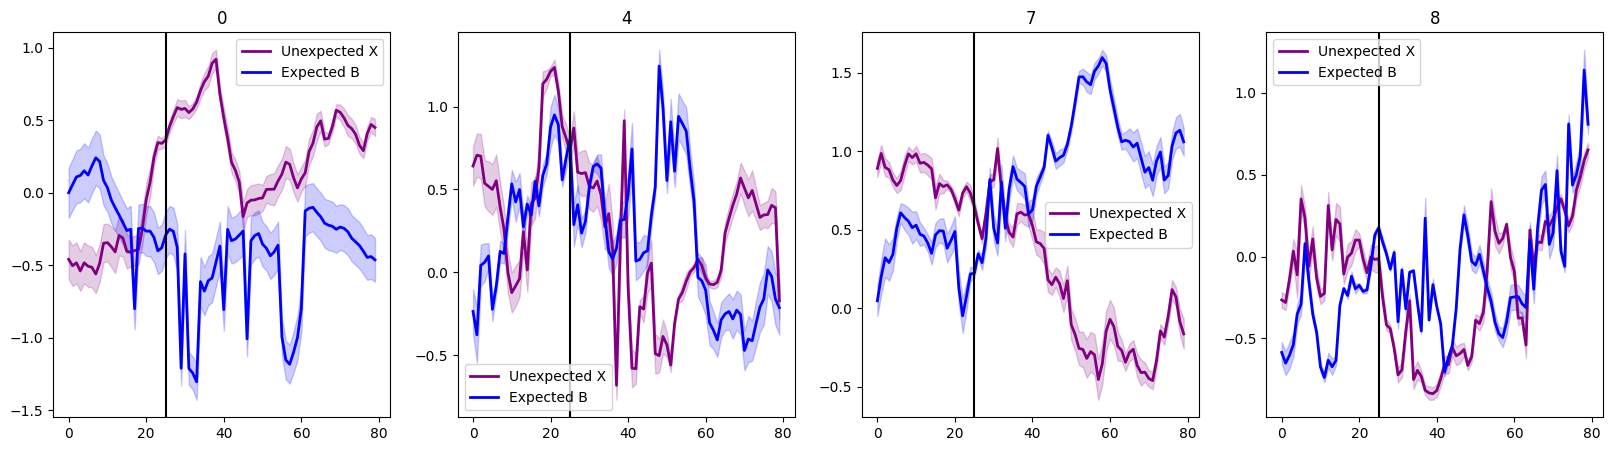

In [186]:
# Pupil Size near reward (Control)

unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-25,data_ctl[ani]['reward_indices'][trial]+55)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-25,data_ctl[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(1, 4, figsize=(20, 5)) 
axes = axes.flatten()
t_frames = 80
for i, ani in enumerate([0,4,7,8]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][:4]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][unexp_rw[ani][7:14]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_ctl[ani]['pupil'][exp_rw[ani][:4]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_title(f'{ani}')
    ax.legend()



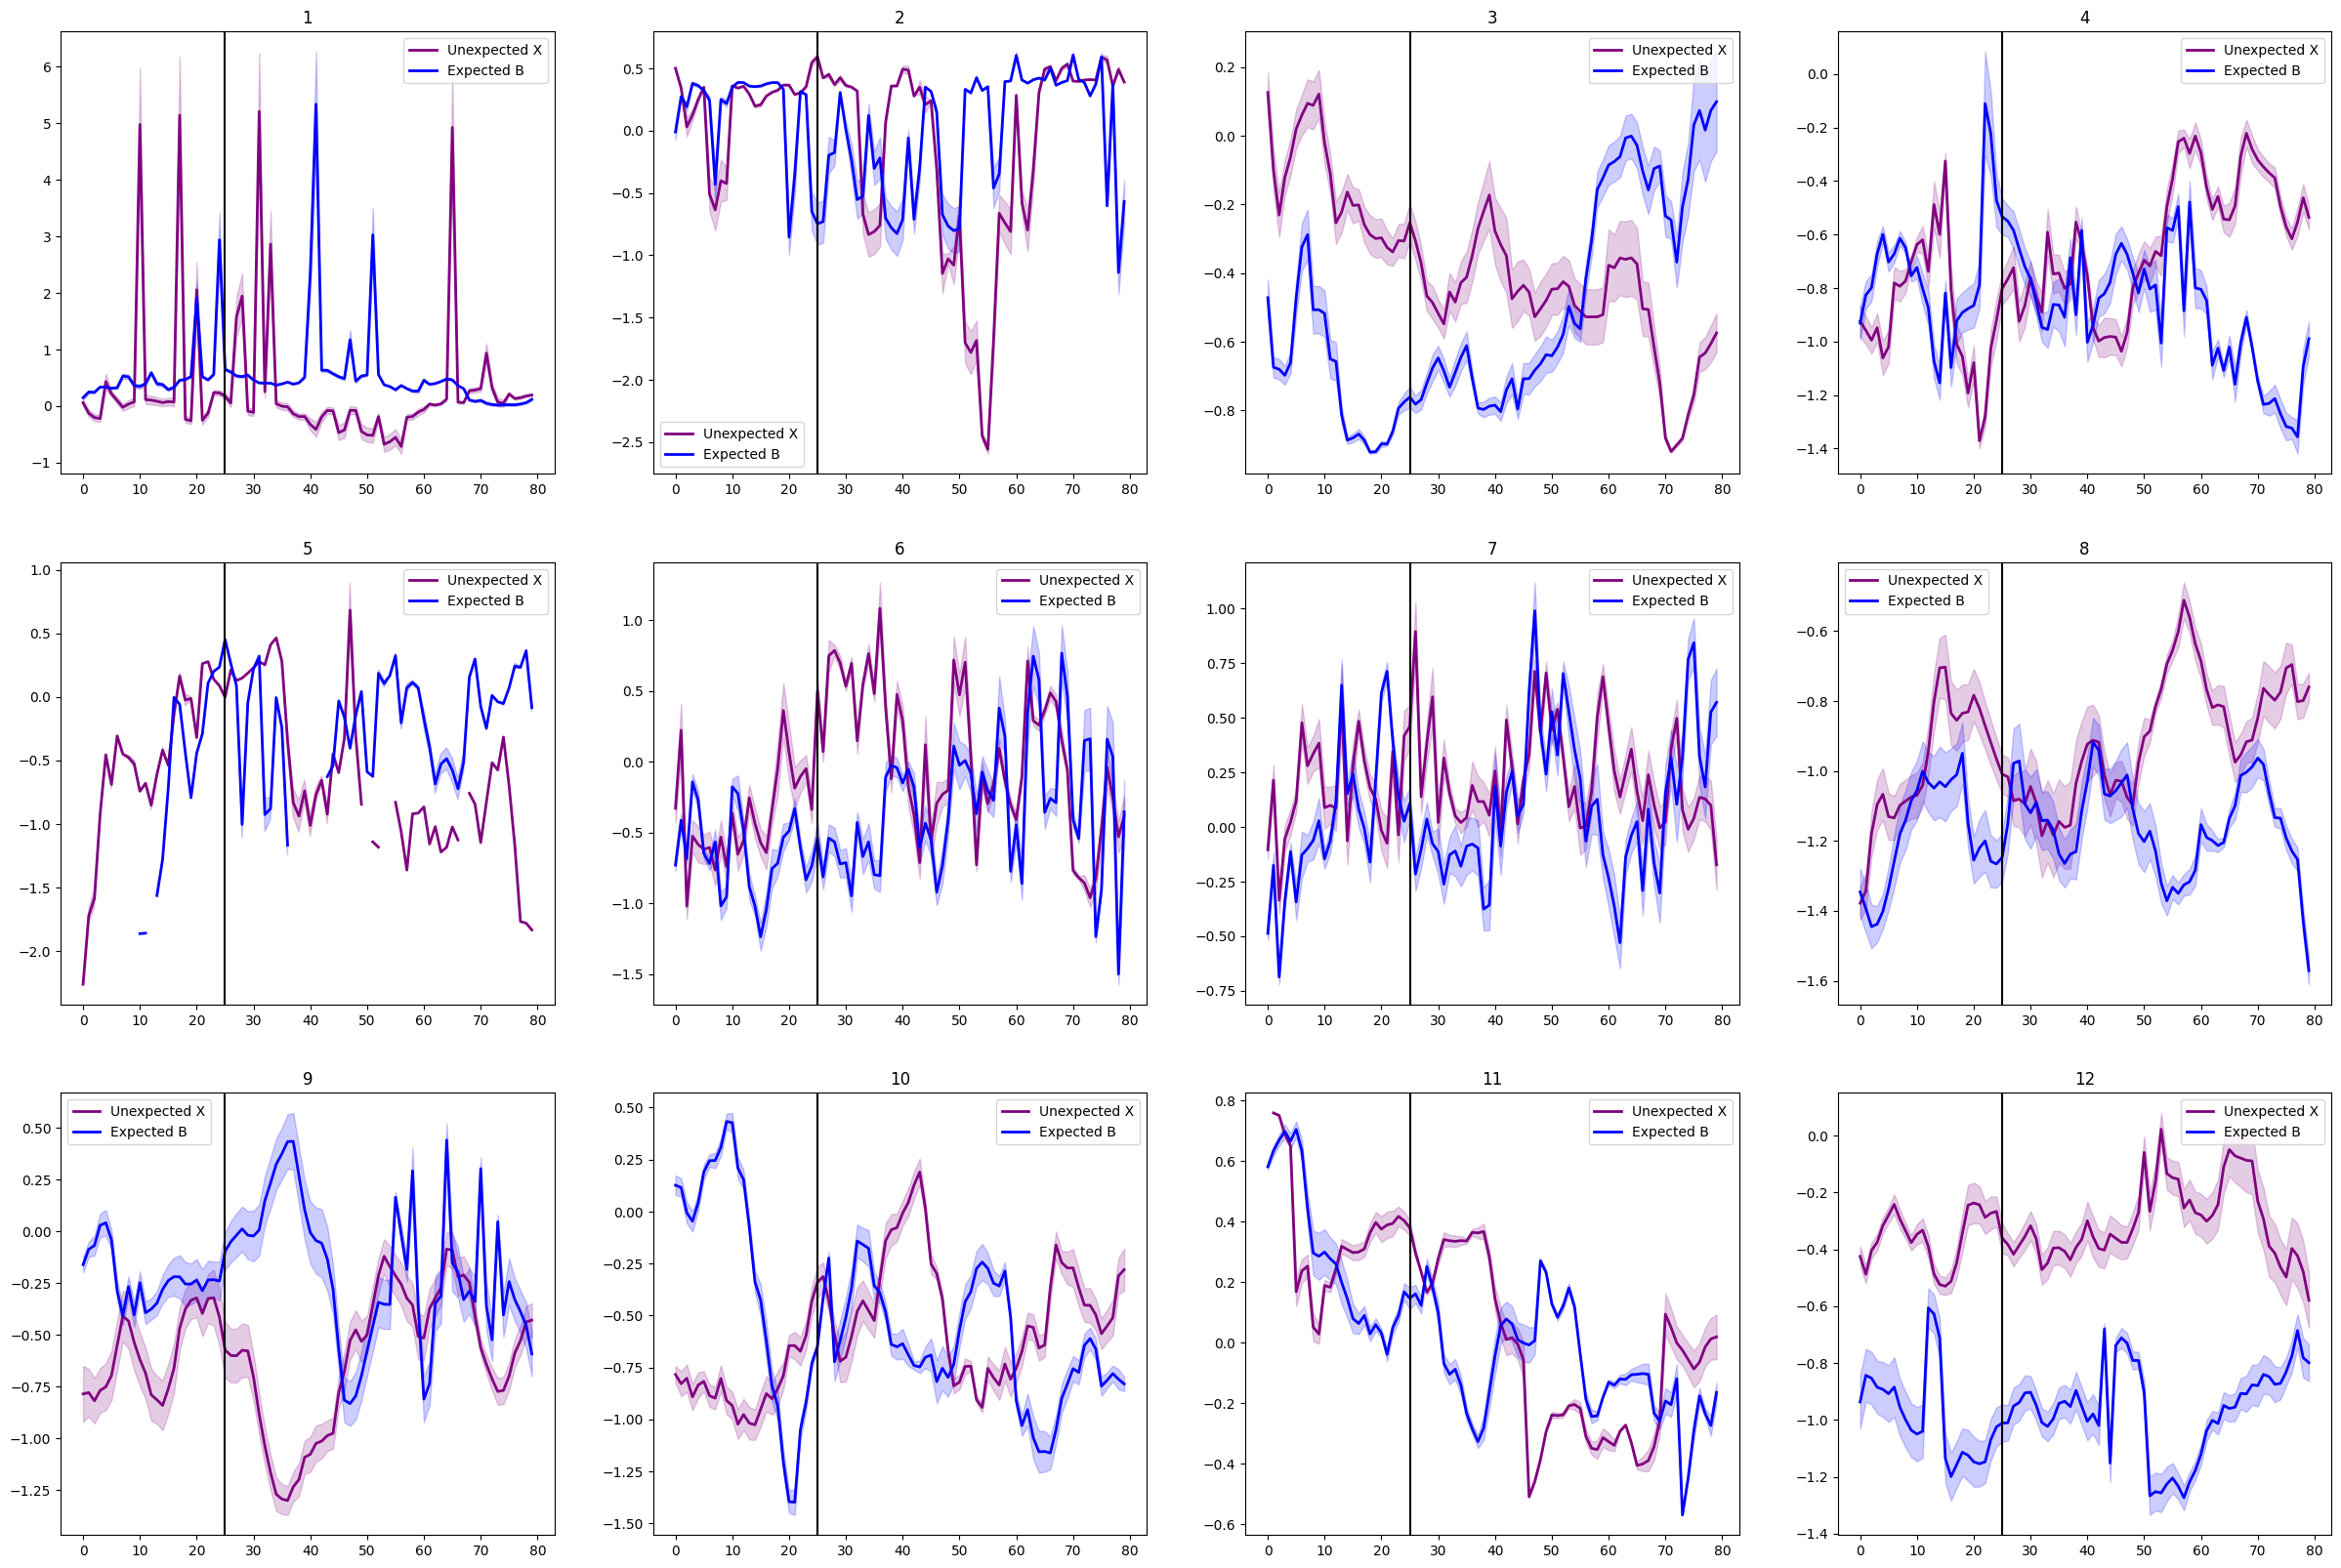

In [187]:
# Pupil Size near reward (tst)
unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-25,data_tst[ani]['reward_indices'][trial]+55)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-25,data_tst[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 4, figsize=(30, 20)) 
axes = axes.flatten()
t_frames = 80
for i, ani in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][:4]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][7:12]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][exp_rw[ani][:4]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_title(f'{ani}')
    ax.legend()



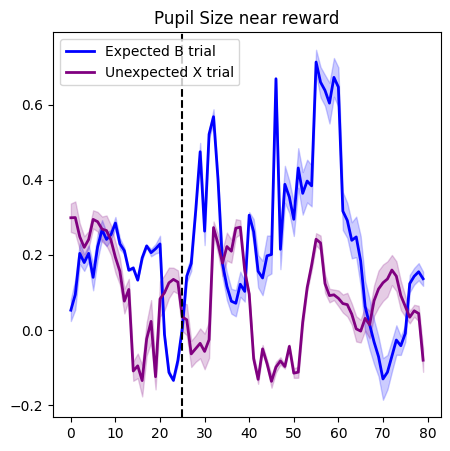

In [ ]:
# Pupil Size near reward averaged (Ctl)

fig,axes = plt.subplots(figsize=(5,5))
unexp_rw = {}
exp_rw = {}
for ani in data_ctl:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial]-25,data_ctl[ani]['reward_indices'][trial]+55)) 
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        if trial < data_ctl[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_ctl[ani]['reward_indices'][trial-1]-25,data_ctl[ani]['reward_indices'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_rw[ani][:7]] for ani in [0,4,7,8]]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_rw[ani][:7]] for ani in [0,4,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
# af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_rw[ani][21:28]] for ani in [0,4,7,8]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes.set_title('Pupil Size near reward')
axes.axvline(x=25, color='k', linestyle='--')
# plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes.legend()

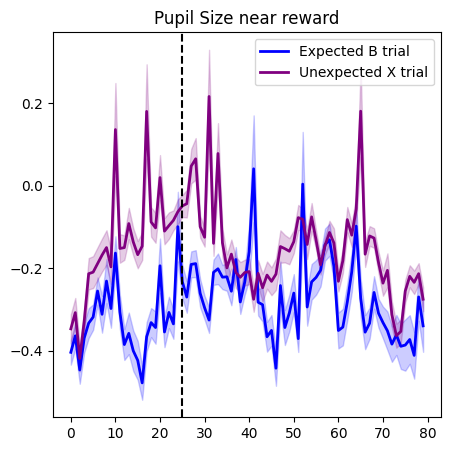

In [ ]:
# Pupil Size near reward averaged (tst)

fig,axes = plt.subplots(figsize=(5,5))
unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-25,data_tst[ani]['reward_indices'][trial]+55)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-25,data_tst[ani]['reward_indices'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_rw[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_rw[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
# af.plot_shaded_error(axes, range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][21:28]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes.set_title('Pupil Size near reward')
axes.axvline(x=25, color='k', linestyle='--')
# plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes.legend()

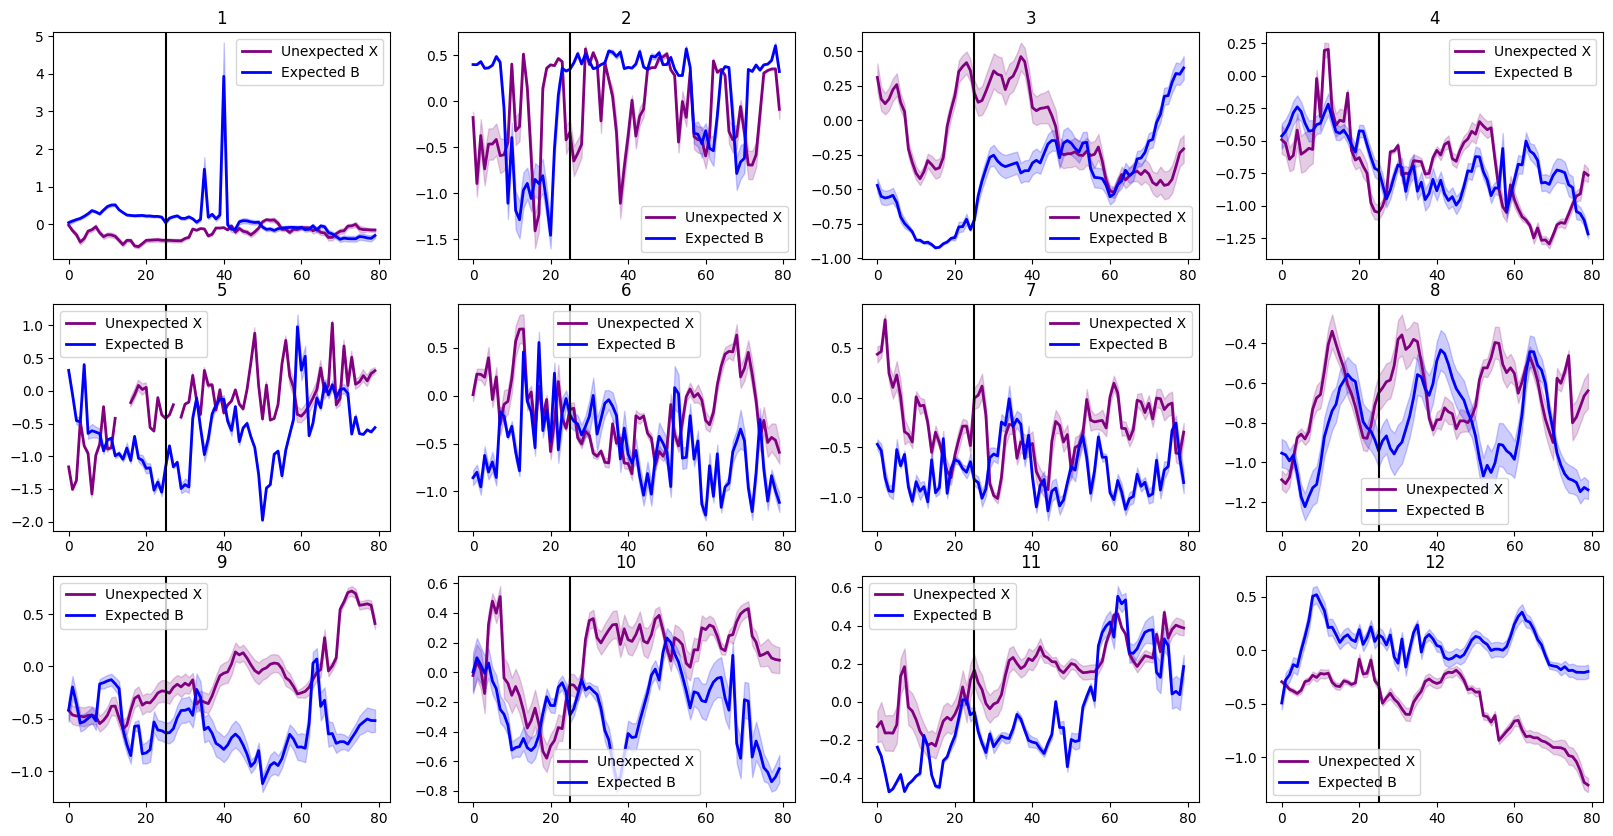

In [136]:
# Pupil size near grating 2 (Ctl)

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_ctl[ani]['grating_indices']['gr_2'][trial]-25,data_ctl[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_ctl[ani]['grating_indices']['gr_2'][trial-1]-25,data_ctl[ani]['grating_indices']['gr_2'][trial-1]+55))

fig, axes = plt.subplots(3, 4, figsize=(20, 10)) 
axes = axes.flatten()
t_frames = 80
for i, ani in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_grat[ani][:5]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][7:12]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][exp_grat[ani][:5]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_title(f'{ani}')
    ax.legend()


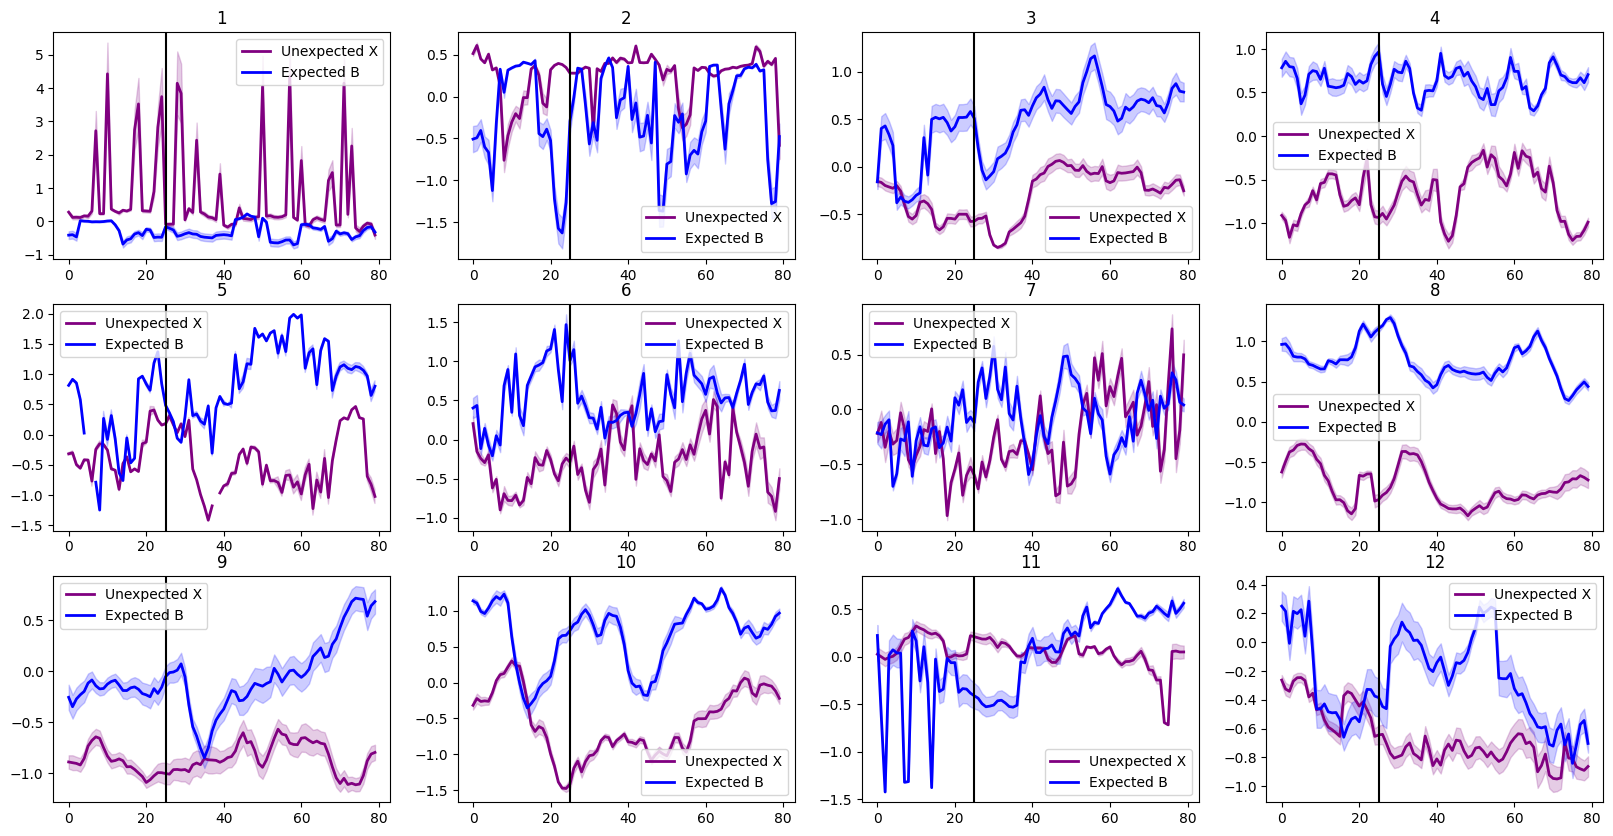

In [137]:
# Pupil Size near grating 2 (Test)

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial]-25,data_tst[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial-1]-25,data_tst[ani]['grating_indices']['gr_2'][trial-1]+55))

fig, axes = plt.subplots(3, 4, figsize=(20, 10)) 
axes = axes.flatten()
t_frames = 80
for i, ani in enumerate([1,2,3,4,5,6,7,8,9,10,11,12]):
    ax = axes[i]
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_grat[ani][:5]], color='purple', alpha=0.2, label='Unexpected X')
    # af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][unexp_rw[ani][7:14]], color='purple', alpha=0.2, style='dash', label='Expected X')
    af.plot_shaded_error(ax, range(t_frames), data_tst[ani]['pupil'][exp_grat[ani][7:12]], color='blue', alpha=0.2, label= 'Expected B')
    ax.axvline([25], color='black')
    ax.set_title(f'{ani}')
    ax.legend()

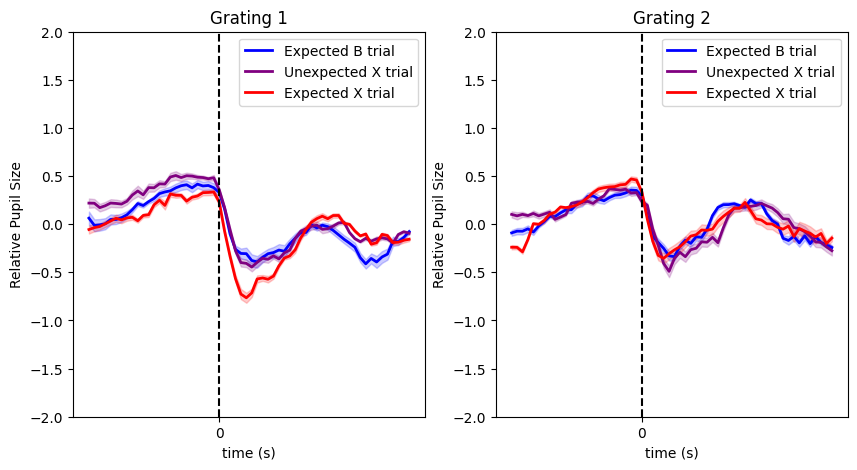

In [334]:
# Pupil Size near gratings averaged (Ctl)

fig,axes = plt.subplots(1,2,figsize=(10,5))

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_1'][trial-1])

t_frames = 60
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_grat[ani][:4]] for ani in [0,4,5,7,8]]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][:4]] for ani in [0,4,5,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [0,4,5,7,8]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[0].set_title('Grating 1')
axes[0].axvline(x=24, color='k', linestyle='--')
plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='Relative Pupil Size')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_ctl:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial])
    for trial in data_ctl[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(data_ctl[ani]['grating_indices']['gr_2'][trial-1])

t_frames = 60
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][exp_grat[ani][:4]] for ani in [0,4,5,7,8]]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][:4]] for ani in [0,4,5,7,8]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_ctl[ani]['pupil'][unexp_grat[ani][6:10]] for ani in [0,4,5,7,8]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[1].set_title('Grating 2')
axes[1].axvline(x=24, color='k', linestyle='--')
plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='Relative Pupil Size')
axes[1].legend()

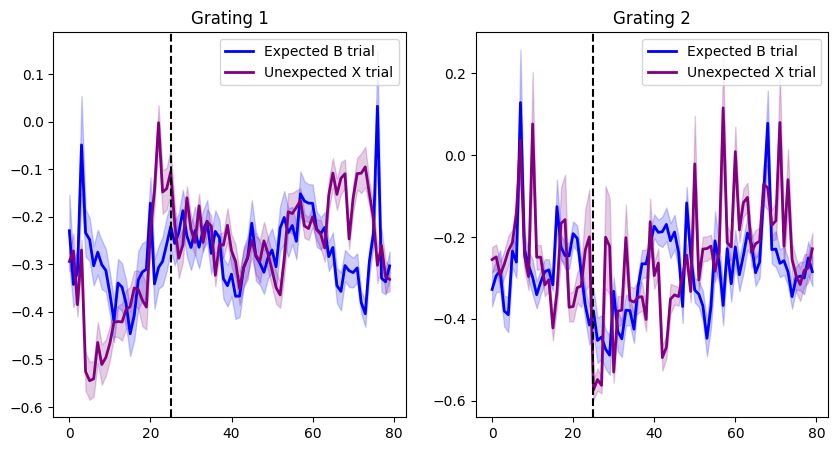

In [139]:
# Pupil Size near gratings averaged (tst)

fig,axes = plt.subplots(1,2,figsize=(10,5))

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_1'][trial]-25,data_tst[ani]['grating_indices']['gr_1'][trial]+55))
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_1'][trial-1]-25,data_tst[ani]['grating_indices']['gr_1'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_grat[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='blue', alpha=0.2, ylim = 0,  label= 'Expected B trial')
af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
# af.plot_shaded_error(axes[0], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][21:28]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[0].set_title('Grating 1')
axes[0].axvline(x=25, color='k', linestyle='--')
# plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes[0].legend()

unexp_grat = {}
exp_grat = {}
for ani in data_tst:
    unexp_grat[ani] = []
    exp_grat[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        unexp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial]-25,data_tst[ani]['grating_indices']['gr_2'][trial]+55))
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        exp_grat[ani].append(range(data_tst[ani]['grating_indices']['gr_2'][trial-1]-25,data_tst[ani]['grating_indices']['gr_2'][trial-1]+55))

t_frames = 80
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][exp_grat[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='blue', alpha=0.2, label= 'Expected B trial')
af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][:7]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1) ,color='purple', alpha=0.2,label = 'Unexpected X trial')
# af.plot_shaded_error(axes[1], range(t_frames), np.mean(np.stack([data_tst[ani]['pupil'][unexp_grat[ani][21:28]] for ani in [1,2,3,4,5,6,7,8,9,10,11,12]]), axis = 1),color='red', alpha=0.2,label= 'Expected X trial')
axes[1].set_title('Grating 2')
axes[1].axvline(x=25, color='k', linestyle='--')
# plt.setp(axes,ylim=[-2,2], xticks=[24], xticklabels=['0'],xlabel='time (s)', ylabel='lick (hz)')
axes[1].legend()

In [193]:
# Preprocess Pupil data
desktop_path = os.path.expanduser(r"C:\Users\HAOXUAN YIN\Desktop\v1ctldata_full.pkl")
with open(desktop_path, 'rb') as f:
    data_ctl = pickle.load(f)
    data_ctl.pop(13) # no speed and lick in this animal's tst data

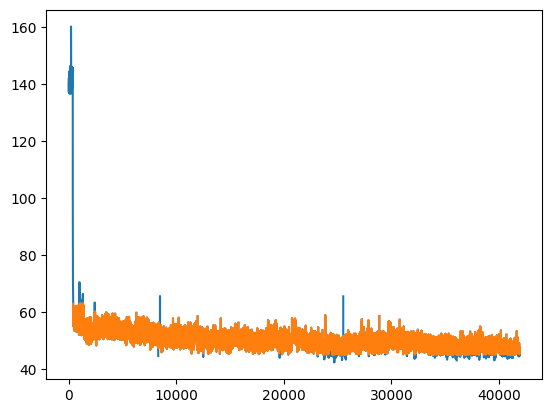

In [194]:
ani = 7
pupil = data_ctl[ani]['pupil']
plt.plot(pupil)
lower_bound = np.nanpercentile(pupil, 1)
upper_bound = np.nanpercentile(pupil, 99)
pupil = np.where(
    (data_ctl[ani]['pupil'] > upper_bound) | (data_ctl[ani]['pupil'] < lower_bound),
    np.nan,
    data_ctl[ani]['pupil']
)
plt.plot(pupil)

In [ ]:
slice(data_tst[7]['grating_indices']['gr_2'][15]-20,data_tst[7]['grating_indices']['gr_2'][15]+40)

(4326, 4386)

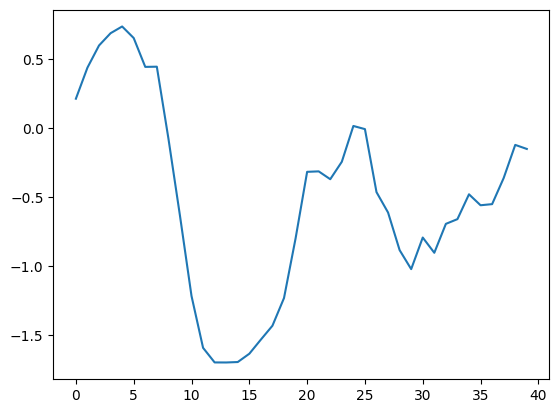

In [224]:
ani= 10
tri = data_tst[ani]['unpred_trials']['gr_2'][2]

plt.plot(data_tst[ani]['pupil'][slice(data_tst[ani]['grating_indices']['gr_2'][tri]-20,data_tst[ani]['grating_indices']['gr_2'][tri]+20)])

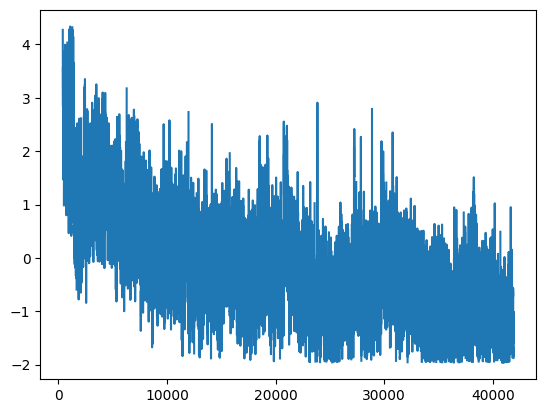

In [142]:
pupil = (pupil - np.nanmean(pupil)) / np.nanstd(pupil)
plt.plot(pupil)

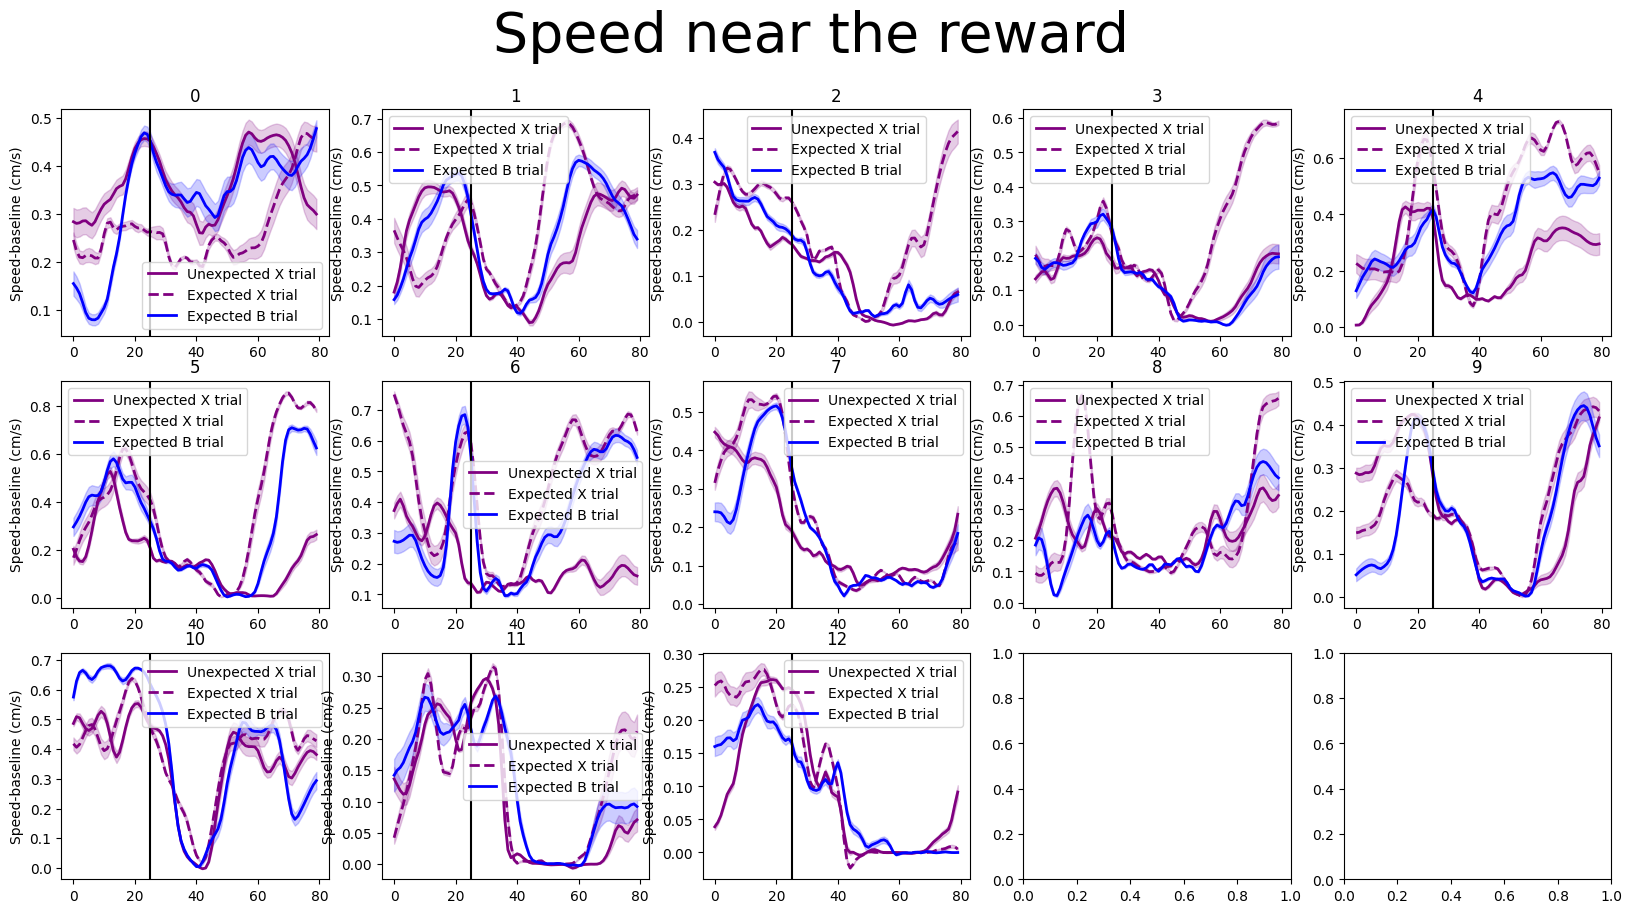

In [143]:
# SPEED NEAR THE REWARD FOR EACH ANIMAL

unexp_rw = {}
exp_rw = {}
for ani in data_tst:
    unexp_rw[ani] = []
    exp_rw[ani] = []
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:    # index out of range,,, so
            unexp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial]-25,data_tst[ani]['reward_indices'][trial]+55)) 
    for trial in data_tst[ani]['unpred_trials']['gr_2']:
        if trial < data_tst[ani]['reward_indices'].shape[0]:
            exp_rw[ani].append(range(data_tst[ani]['reward_indices'][trial-1]-25,data_tst[ani]['reward_indices'][trial-1]+55))

fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
fig.suptitle('Speed near the reward', fontsize = 40)
t_frames = range(80)
for i, ani in enumerate(data_tst):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    af.plot_shaded_error(ax, t_frames, data_tst[ani]['speed'][np.array(unexp_rw[ani][:7])], color='purple', alpha=0.2, label='Unexpected X trial')
    af.plot_shaded_error(ax, t_frames, data_tst[ani]['speed'][np.array(unexp_rw[ani][20:27])], color='purple', alpha=0.2, style='dash', label='Expected X trial')
    af.plot_shaded_error(ax, t_frames, data_tst[ani]['speed'][np.array(exp_rw[ani][7:14])], color='blue', alpha=0.2, label= 'Expected B trial')
    ax.axvline([25], color='black')
    ax.set_ylabel('Speed-baseline (cm/s)')
    ax.set_title(f'{ani}')
    ax.legend()